# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [2]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [3]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [5]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("hot_design_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

FileNotFoundError: [Errno 2] No such file or directory: '/home/azureuser/localfiles/tesseract-jax/examples/ansys/hot_design_tess'

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [ ]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

{
    "a": jnp.array([1.0, 2.0, 3.0], dtype=jnp.float32),
    "b": jnp.array(2.0, dtype=jnp.float32),
    "c": {"d": jnp.array(3.0, dtype=jnp.float32)},
}

flat_array, pytree_def = jax.tree_util.tree_flatten(initial_params)


design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
        "static_parameters": [n_chains, n_edges_per_chain + 1],
        "string_parameters": [],
        "mesh_tesseract": TesseractReference(bar_3d_tess),
        "grid_size": [Lx, Ly, Lz],
        "grid_elements": [Nx, Ny, Nz],
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 360
Number of faces: 708
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

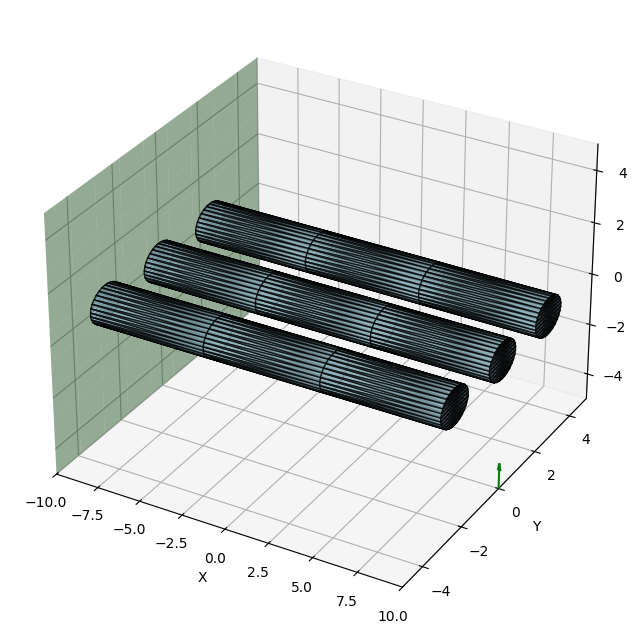

In [ ]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

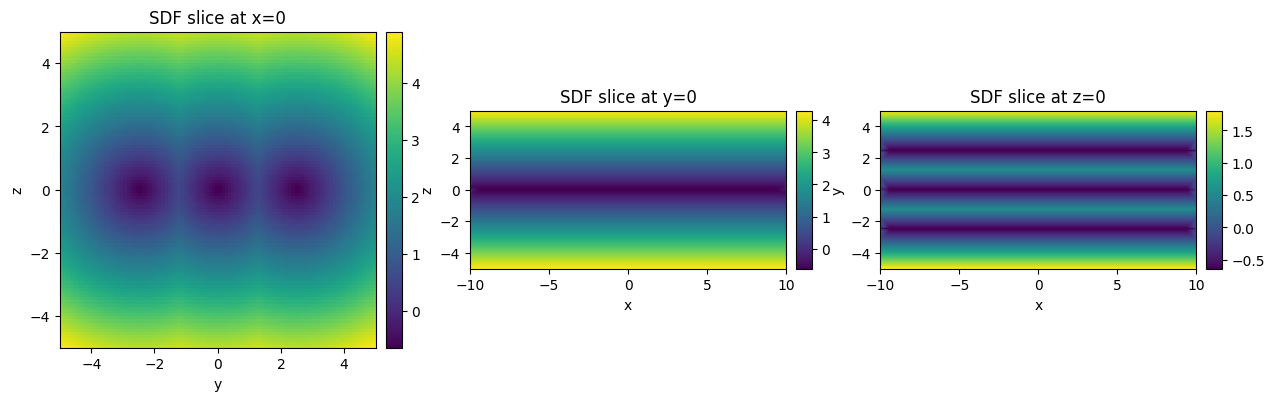

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [ ]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params.flatten(),
#             "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
#             "static_parameters": [n_chains, n_edges_per_chain + 1],
#             "string_parameters": [],
#             "mesh_tesseract": TesseractReference(bar_3d_tess),
#             "grid_size": [Lx, Ly, Lz],
#             "grid_elements": [Nx, Ny, Nz],
#             "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
#             "normalize_jacobian": True,
#         },
#     )["sdf"],
#     initial_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [ ]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, 0, 6)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     primal, vjp_fun = jax.vjp(
#         lambda params, eps=eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 "non_differentiable_parameters": jnp.array(
#                     [bar_radius], dtype=jnp.float32
#                 ),
#                 "static_parameters": [n_chains, n_edges_per_chain + 1],
#                 "string_parameters": [],
#                 "mesh_tesseract": TesseractReference(bar_3d_tess),
#                 "grid_size": [Lx, Ly, Lz],
#                 "grid_elements": [Nx, Ny, Nz],
#                 "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
#                 "normalize_jacobian": True,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 6.239625508897007e-05, rho max: 0.7989268898963928


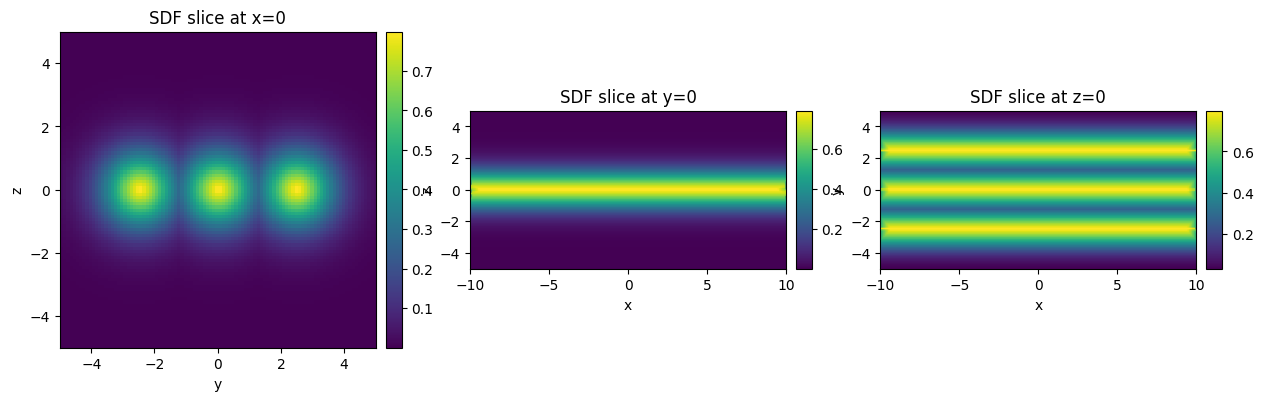

In [ ]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.3333333432674408, max: 4.0


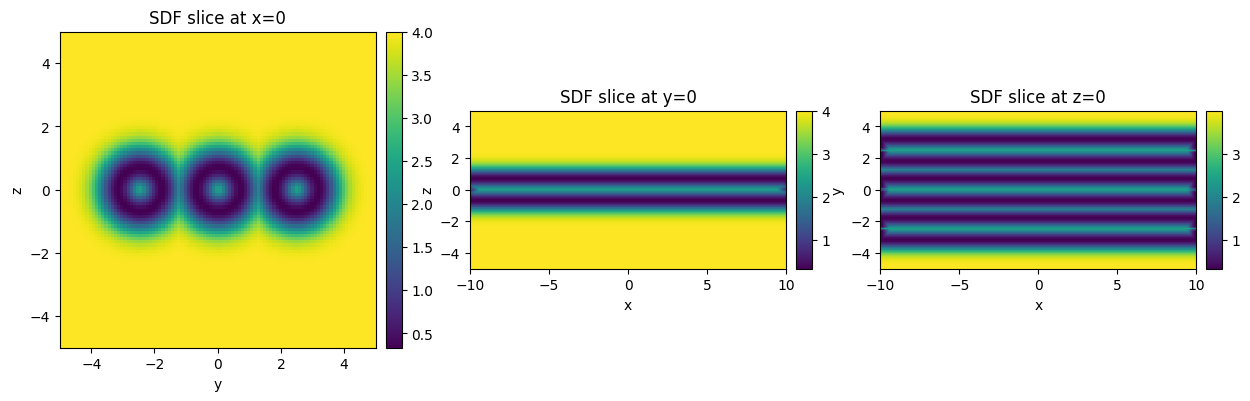

In [ ]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 5, scale=2.0)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [6]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 4,
        "max_points": 5000,
        "max_cells": 5000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

NameError: name 'Lx' is not defined

Lets check the gradient of the meshing Tesseract

In [246]:
# max_points = 5000
# max_cells = 5000

# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
#             "field_values": rho,
#             "max_subdivision_levels": 4,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [247]:
# # Lets export it to a .vtk using pyvista
# import pyvista as pv


# def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
#     """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

#     Args:
#         pts: Array of point coordinates, shape (N, 3).
#         faces: Array of hexahedral cell connectivity, shape (M, 8).

#     Returns:
#         PyVista mesh representing the hexahedral grid.
#     """
#     # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
#     cell_type = pv.CellType.HEXAHEDRON
#     cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

#     # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
#     n_cells = faces.shape[0]
#     cells = np.empty((n_cells, 9), dtype=np.int64)
#     cells[:, 0] = 8  # Each cell has 8 points
#     cells[:, 1:9] = faces

#     # Flatten the cells array for PyVista
#     cells = cells.flatten()

#     return pv.UnstructuredGrid(cells, cell_types, pts)


# # convert arrays to numpy
# pts_np = np.array(adaptive_mesh["points"])
# cells_np = np.array(adaptive_mesh["faces"])

# hex_mesh = hex_to_pyvista(pts_np, cells_np)

# print(hex_mesh)

# hex_mesh.save("fem_shapeopt_mesh.vtk")

## Boundary Conditions

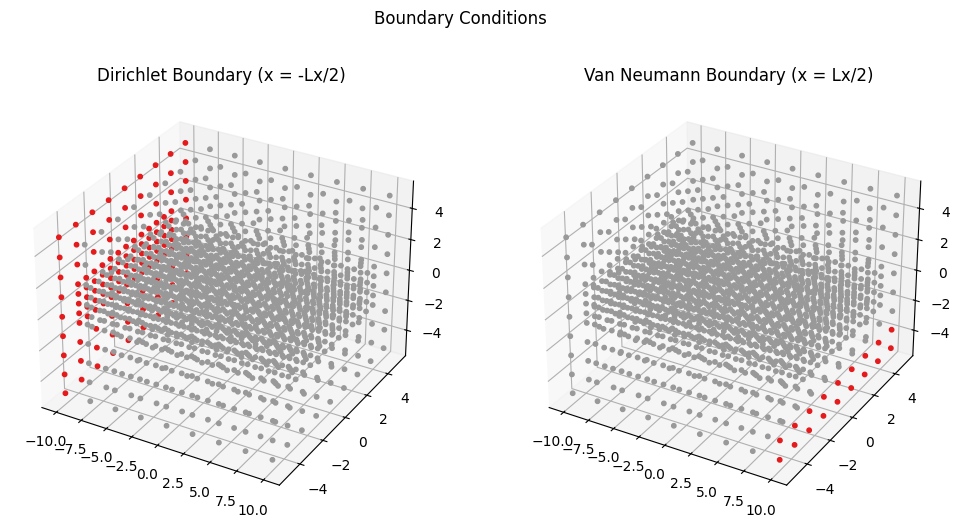

In [248]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 6),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 6),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [249]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [250]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-06 21:50:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 21:50:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 21:50:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-06 21:50:42][DEBUG] jax_fem: Done pre-computations, took 0.20529389381408691 [s]
[11-06 21:50:42][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 21:50:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 21:50:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 21:50:42][DEBUG] jax_fem: Start timing
[11-06 21:50:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 21:50:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.3399 seconds
[11-06 21:50:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 21:50:42][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 res = 1.0
[11-06 21:50:42][DEBUG] jax_fem: Solving linear system...
[11-06 21:50:42][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-06 21:50:43][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.477620266069101e-10
[11-06 21:50:43][DEBUG] 

Compliance: 453.4234


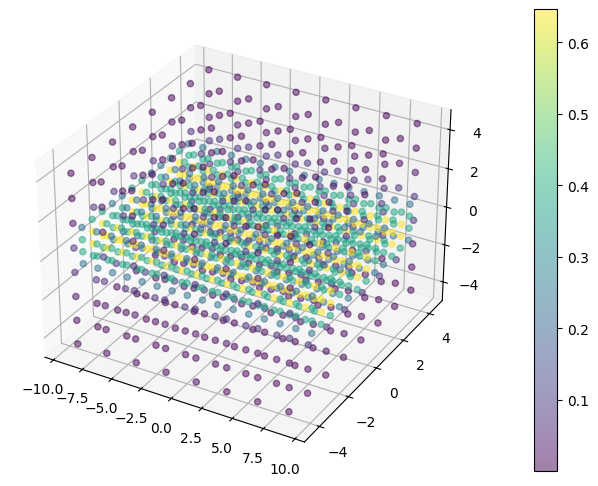

In [251]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [ ]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    cell_values: jnp.ndarray,
    mesh: dict,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        cell_values: Material density values for each mesh cell.
        mesh: Mesh dictionary.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    mesh = stop_grads_int(mesh)

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": cell_values,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [253]:
# get the gradient of the loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(
    jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
)
print("Grad shape:", grad.shape)

[11-06 21:50:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 21:50:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 21:50:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-06 21:50:50][DEBUG] jax_fem: Done pre-computations, took 0.21903419494628906 [s]
[11-06 21:50:50][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 21:50:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 21:50:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 21:50:50][DEBUG] jax_fem: Start timing
[11-06 21:50:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 21:50:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.3407 seconds
[11-06 21:50:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 21:50:50][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 res = 1.0
[11-06 21:50:50][DEBUG] jax_fem: Solving linear system...
[11-06 21:50:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-06 21:50:50][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.477620266069101e-10
[11-06 21:50:50][DEBUG] 

Grad shape: (5000, 1)


Voxel center points shape: (1184, 3)
1184


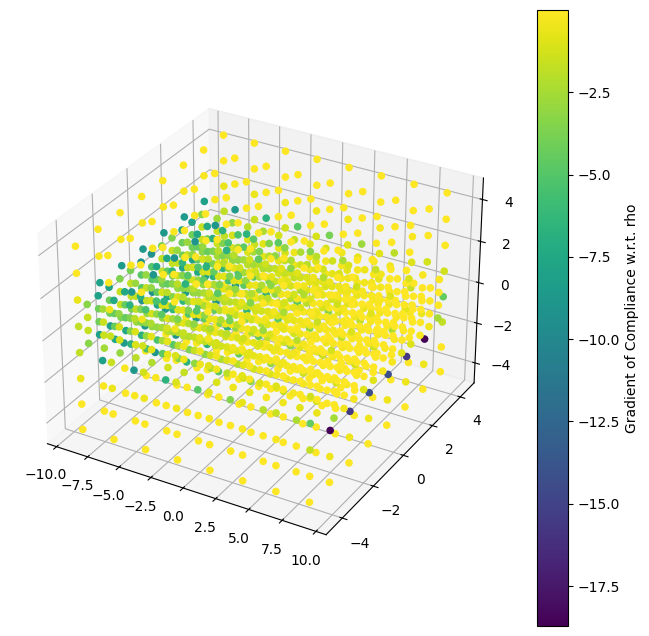

In [254]:
# print a 3D point cloud of the gradient field
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
voxel_center_points = jnp.mean(pts_coords[hex_cells], axis=1)
print("Voxel center points shape:", voxel_center_points.shape)
print(mesher_out["mesh"]["n_faces"])
sc = ax.scatter(
    voxel_center_points[:, 0],
    voxel_center_points[:, 1],
    voxel_center_points[:, 2],
    c=grad[: mesher_out["mesh"]["n_faces"], 0],
    cmap="viridis",
    alpha=1.0,
)
# lets add a colorbar
plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [ ]:
max_points = 9000
max_cells = 9000


def loss(
    rho: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        rho: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 5, scale=2.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 4,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [258]:
# get grads of loss w.r.t. rho
grad_loss = jax.grad(loss)
print(rho.shape)
grad = grad_loss(rho)

(200, 100, 100)


[11-06 21:51:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 21:51:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 21:51:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 21:51:46][DEBUG] jax_fem: Done pre-computations, took 0.2574303150177002 [s]
[11-06 21:51:46][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 21:51:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 21:51:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 21:51:47][DEBUG] jax_fem: Start timing
[11-06 21:51:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 21:51:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.3459 seconds
[11-06 21:51:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 21:51:47][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

Grad min: -18.713556 Grad max: -2.913098e-06


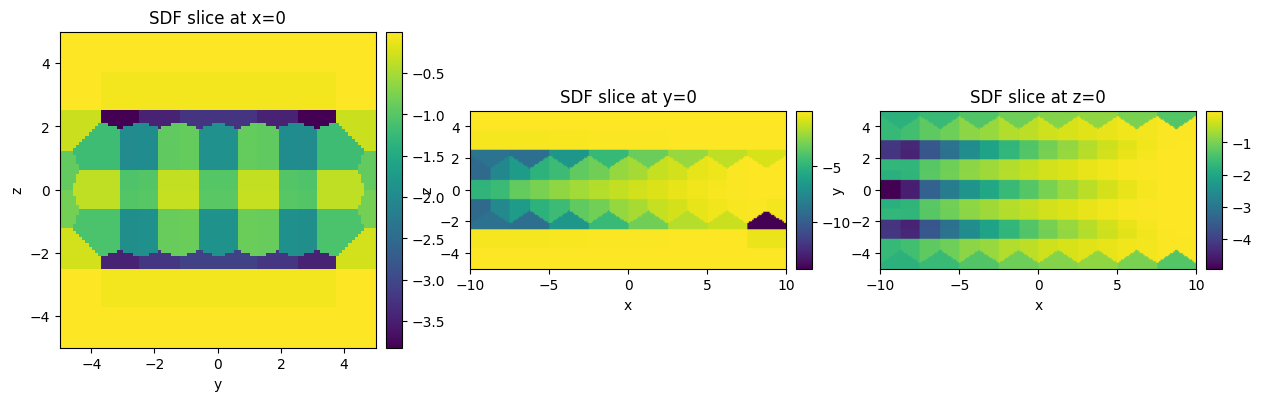

In [259]:
# plot the grad field
plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)
print("Grad min:", jnp.min(grad), "Grad max:", jnp.max(grad))

In [ ]:
max_points = 9000
max_cells = 9000


def loss(
    params: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
            "normalize_jacobian": True,
        },
    )["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 5, scale=2.0)
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 4,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [269]:
import optax

# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.1, transition_steps=50, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss)

for i in range(50):
    loss_value, grads = grad_fn(params)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[11-06 22:25:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:25:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:25:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:25:01][DEBUG] jax_fem: Done pre-computations, took 0.21652936935424805 [s]
[11-06 22:25:01][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 22:25:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:25:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:25:01][DEBUG] jax_fem: Start timing
[11-06 22:25:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:25:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.3451 seconds
[11-06 22:25:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:25:01][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 r

[[[ 0.00516192 -0.00374078 -0.01498215]
  [-0.01771013 -0.01422619  0.00396246]
  [-0.01248167 -0.02139374 -0.00566502]
  [-0.00509424 -0.01849545 -0.01720053]]

 [[ 0.01314077 -0.01024141 -0.01081359]
  [-0.01339767 -0.01400857 -0.00540683]
  [-0.00723073 -0.02446151 -0.01420934]
  [-0.01235123 -0.02576628  0.00287285]]

 [[-0.01226782 -0.03126489 -0.00861265]
  [-0.00642474 -0.00978118 -0.01482711]
  [-0.01507375 -0.01687481 -0.00338229]
  [-0.00938709 -0.00737072 -0.00574775]]]
[[[-10.         -2.5         0.       ]
  [ -3.3333333  -2.5         0.       ]
  [  3.3333333  -2.5         0.       ]
  [ 10.         -2.5         0.       ]]

 [[-10.          0.          0.       ]
  [ -3.3333333   0.          0.       ]
  [  3.3333333   0.          0.       ]
  [ 10.          0.          0.       ]]

 [[-10.          2.5         0.       ]
  [ -3.3333333   2.5         0.       ]
  [  3.3333333   2.5         0.       ]
  [ 10.          2.5         0.       ]]]
Iteration 1, Loss: 453.42


[11-06 22:25:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:25:16][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:25:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:25:16][DEBUG] jax_fem: Done pre-computations, took 0.2169206142425537 [s]
[11-06 22:25:16][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 22:25:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:25:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:25:16][DEBUG] jax_fem: Start timing
[11-06 22:25:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:25:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3399 seconds
[11-06 22:25:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:25:16][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[-0.00110616  0.0011312  -0.00025849]
  [ 0.00751336  0.00103787  0.00036421]
  [-0.00608605 -0.00053057 -0.0082131 ]
  [-0.00905077  0.00111295  0.00340821]]

 [[ 0.01790352  0.00467084 -0.00413827]
  [ 0.00069923 -0.00138428  0.00059365]
  [ 0.00181617 -0.00632479  0.00017094]
  [-0.0011422  -0.00194728  0.01128298]]

 [[ 0.00390164 -0.00149272 -0.00549529]
  [-0.00713944 -0.00526593 -0.00040638]
  [-0.00313774  0.00403209 -0.00311552]
  [ 0.00198704  0.00078081 -0.00035398]]]
[[[-10.          -2.4000003    0.09999994]
  [ -3.3333333   -2.4         -0.09999976]
  [  3.3333333   -2.4          0.09999983]
  [ 10.          -2.4          0.09999995]]

 [[-10.           0.09999991   0.0999999 ]
  [ -3.3333333    0.09999993   0.09999982]
  [  3.3333333    0.09999996   0.09999993]
  [ 10.           0.09999996  -0.09999966]]

 [[-10.           2.6          0.09999988]
  [ -3.3333333    2.6          0.09999993]
  [  3.3333333    2.6          0.0999997 ]
  [ 10.           2.6          0.0999

[11-06 22:25:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:25:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:25:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:25:31][DEBUG] jax_fem: Done pre-computations, took 0.21762347221374512 [s]
[11-06 22:25:31][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 22:25:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:25:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:25:31][DEBUG] jax_fem: Start timing
[11-06 22:25:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:25:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.3437 seconds
[11-06 22:25:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:25:32][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 r

[[[ 4.72231448e-04  1.31602006e-04 -2.11682112e-04]
  [ 4.23368110e-05  1.10105949e-03  4.64542257e-03]
  [ 2.67085966e-06  9.39442660e-04 -8.55210063e-04]
  [-1.67761536e-05  1.19593705e-03  2.41742563e-03]]

 [[ 3.76936630e-03 -1.28075975e-04 -6.71680458e-03]
  [ 1.45530066e-05  1.64747806e-04 -8.85739457e-03]
  [-1.00042766e-04  1.55980932e-04 -8.50692159e-04]
  [ 4.73206281e-04 -1.31941953e-04  5.45655610e-03]]

 [[ 3.06925550e-03 -3.93010024e-03 -5.06485486e-03]
  [-4.43015733e-06 -3.35838180e-03 -4.46619280e-03]
  [ 4.19918433e-05 -2.98223621e-03 -2.58165249e-03]
  [-8.83406319e-05 -1.85519806e-03  2.20143190e-03]]]
[[[-10.          -2.3575044    0.16813633]
  [ -3.3333333   -2.3387184   -0.1733833 ]
  [  3.3333333   -2.331314     0.19908822]
  [ 10.          -2.3377187    0.15114823]]

 [[-10.           0.13000491   0.18899593]
  [ -3.3333333    0.1738461    0.15835612]
  [  3.3333333    0.18333113   0.16596612]
  [ 10.           0.17227316  -0.18845361]]

 [[-10.           2.67

[11-06 22:25:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:25:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:25:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:25:47][DEBUG] jax_fem: Done pre-computations, took 0.2180922031402588 [s]
[11-06 22:25:47][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-06 22:25:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:25:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:25:47][DEBUG] jax_fem: Start timing
[11-06 22:25:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:25:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.3342 seconds
[11-06 22:25:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:25:48][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.4353148e-03  1.0680265e-03  7.8911608e-04]
  [ 6.9474707e-05  5.9740146e-04  7.1217068e-03]
  [ 1.3692879e-04  9.8977413e-04 -1.1065579e-03]
  [-9.0836795e-05  1.1905577e-03  2.0171290e-03]]

 [[ 1.2437464e-03 -3.3421641e-06 -1.1260966e-02]
  [ 1.1627998e-04  3.3564665e-04 -1.3792541e-02]
  [-1.6392501e-04 -2.7599264e-04 -1.7868152e-03]
  [ 1.1347277e-03  5.6368855e-05  5.9721214e-03]]

 [[ 1.0133982e-03 -3.5532105e-03 -6.6123935e-03]
  [ 5.7691509e-06 -5.3594722e-03 -8.3039552e-03]
  [-1.2680009e-05 -2.3626592e-03 -2.6465643e-03]
  [-6.8349393e-05 -1.8718059e-03  1.8410527e-03]]]
[[[-10.          -2.3268857    0.22158928]
  [ -3.3333333   -2.2964885   -0.2585191 ]
  [  3.3333333   -2.281175     0.28067917]
  [ 10.          -2.2938778    0.18153632]]

 [[-10.           0.15387294   0.28030553]
  [ -3.3333333    0.23006013   0.23611742]
  [  3.3333333    0.24721645   0.22056481]
  [ 10.           0.22834733  -0.27723718]]

 [[-10.           2.7320929    0.29114348]
  [ -3.3333333 

[11-06 22:26:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:26:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:26:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:26:08][DEBUG] jax_fem: Done pre-computations, took 0.7618739604949951 [s]
[11-06 22:26:08][INFO] jax_fem: Solving a problem with 1177 cells, 1643x3 = 4929 dofs.
[11-06 22:26:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:26:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:26:09][DEBUG] jax_fem: Start timing
[11-06 22:26:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:26:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.4457 seconds
[11-06 22:26:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:26:11][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.5543808e-03  5.8417133e-04  1.5147920e-03]
  [ 3.8738930e-05  4.1143311e-04  9.7215353e-03]
  [ 1.2883171e-04  1.4377943e-03 -1.3482819e-03]
  [-1.5972456e-04  1.0563812e-03  1.6652897e-03]]

 [[ 4.8021888e-05 -7.1179227e-04 -1.6032536e-02]
  [ 2.3601644e-04 -3.1069540e-05 -2.0170903e-02]
  [-3.6720143e-04 -3.2580559e-05 -2.4170810e-03]
  [ 1.6944798e-03  9.4036681e-05  6.3376934e-03]]

 [[ 1.4217526e-03 -5.1466725e-03 -9.6811755e-03]
  [-6.0552138e-05 -5.4955357e-03 -1.0213258e-02]
  [-3.9007569e-05 -2.8466154e-03 -4.0954207e-03]
  [ 1.1311241e-04 -1.9397631e-03  1.6420546e-03]]]
[[[-10.          -2.31798      0.26218075]
  [ -3.3333333   -2.2644122   -0.34766126]
  [  3.3333333   -2.2429037    0.35331813]
  [ 10.          -2.261816     0.19966802]]

 [[-10.           0.17340018   0.37459308]
  [ -3.3333333    0.27461874   0.32048386]
  [  3.3333333    0.3000658    0.27204838]
  [ 10.           0.2740569   -0.3673902 ]]

 [[-10.           2.7887323    0.38717228]
  [ -3.3333333 

[11-06 22:26:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:26:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:26:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:26:42][DEBUG] jax_fem: Done pre-computations, took 0.9932823181152344 [s]
[11-06 22:26:42][INFO] jax_fem: Solving a problem with 1100 cells, 1597x3 = 4791 dofs.
[11-06 22:26:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:26:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:26:44][DEBUG] jax_fem: Start timing
[11-06 22:26:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:26:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.2352 seconds
[11-06 22:26:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:26:46][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 4.3611834e-04 -5.3867325e-04  3.5218652e-03]
  [ 8.8338438e-06 -4.1775996e-04  1.3307945e-02]
  [ 1.2964690e-04  6.6040881e-04 -1.2050680e-03]
  [-6.4404687e-04  9.6356991e-04  1.4650746e-03]]

 [[ 4.8874668e-03  1.6361435e-03 -1.8937498e-02]
  [-1.5885303e-04  2.0465408e-03 -2.1101775e-02]
  [-6.5352011e-04  3.6521940e-04 -3.6795407e-03]
  [ 3.1309102e-03  1.6445118e-04  6.3362457e-03]]

 [[ 4.9965712e-04 -2.8226213e-03 -9.7179068e-03]
  [ 2.8765219e-04 -4.0785517e-03 -1.1220437e-02]
  [-5.6350502e-05 -2.1102296e-03 -3.8967074e-03]
  [-4.6421998e-04 -1.8997825e-03  1.6841970e-03]]]
[[[-10.          -2.3182752    0.29080063]
  [ -3.3333333   -2.2389252   -0.4387928 ]
  [  3.3333333   -2.2143223    0.42122862]
  [ 10.          -2.2378893    0.20985062]]

 [[-10.           0.19325739   0.4697598 ]
  [ -3.3333333    0.31232113   0.407845  ]
  [  3.3333333    0.34471136   0.3238696 ]
  [ 10.           0.31241313  -0.4588928 ]]

 [[-10.           2.8445597    0.48446882]
  [ -3.3333333 

[11-06 22:27:11][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:27:11][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:27:11][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:27:12][DEBUG] jax_fem: Done pre-computations, took 0.7415523529052734 [s]
[11-06 22:27:12][INFO] jax_fem: Solving a problem with 1114 cells, 1653x3 = 4959 dofs.
[11-06 22:27:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:27:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:27:12][DEBUG] jax_fem: Start timing
[11-06 22:27:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:27:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.3204 seconds
[11-06 22:27:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:27:13][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.2750096e-03 -4.0155477e-04  5.0691213e-03]
  [ 4.0533909e-05 -1.9775787e-03  1.3857211e-02]
  [ 1.9838690e-04  7.7240745e-04 -1.4696475e-03]
  [-2.9928595e-04  9.2167745e-04  1.2142315e-03]]

 [[ 4.9003381e-03  1.1885595e-03 -2.6917161e-02]
  [ 2.3809049e-04  2.0386435e-03 -3.1974770e-02]
  [-4.8664544e-04  9.1513590e-04 -3.0960378e-03]
  [ 2.0462195e-03  4.2194957e-04  6.2600155e-03]]

 [[ 9.0221839e-04 -2.4537249e-03  1.4830708e-03]
  [-2.2099841e-04 -2.5951378e-03  1.0743344e-03]
  [ 1.5466480e-04 -1.5181676e-03  3.1276309e-04]
  [ 2.4304971e-05 -1.7498613e-03  1.9262837e-03]]]
[[[-10.          -2.3117743    0.30299217]
  [ -3.3333333   -2.2155046   -0.53088117]
  [  3.3333333   -2.191343     0.4853227 ]
  [ 10.          -2.2200131    0.21435255]]

 [[-10.           0.2027239    0.5659539 ]
  [ -3.3333333    0.3369599    0.498809  ]
  [  3.3333333    0.3823565    0.37976786]
  [ 10.           0.34507135  -0.551286  ]]

 [[-10.           2.8969176    0.5828002 ]
  [ -3.3333333 

[11-06 22:27:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:27:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:27:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:27:37][DEBUG] jax_fem: Done pre-computations, took 1.0122239589691162 [s]
[11-06 22:27:37][INFO] jax_fem: Solving a problem with 1156 cells, 1724x3 = 5172 dofs.
[11-06 22:27:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:27:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:27:38][DEBUG] jax_fem: Start timing
[11-06 22:27:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:27:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.5066 seconds
[11-06 22:27:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:27:40][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.1323951e-03 -6.9315254e-04  6.7445221e-03]
  [-6.0490005e-05 -7.6773687e-04  1.0251383e-02]
  [ 3.6042702e-04  8.8693218e-05 -8.9639734e-04]
  [-1.7395674e-05  1.3072701e-03  1.4718042e-03]]

 [[ 5.0953175e-03  7.1172644e-03 -1.1273540e-02]
  [-2.2517261e-04  6.5206164e-03 -1.3563039e-02]
  [-2.9109168e-04  5.0435116e-04 -1.1488153e-03]
  [ 2.9892791e-03  4.1913733e-04  6.1882944e-03]]

 [[ 4.1318146e-04 -2.1993944e-03  1.4002083e-03]
  [ 5.5368928e-06 -1.0386253e-03  2.3726658e-03]
  [ 1.6758034e-04 -1.5233730e-03  4.2729845e-04]
  [ 1.2654896e-05 -1.6174157e-03  2.1131807e-03]]]
[[[-10.          -2.3012843    0.29749405]
  [ -3.3333333   -2.188432    -0.62517506]
  [  3.3333333   -2.1731308    0.5477329 ]
  [ 10.          -2.2069278    0.21488293]]

 [[-10.           0.20572808   0.66184044]
  [ -3.3333333    0.35110185   0.5907805 ]
  [  3.3333333    0.4133264    0.43760055]
  [ 10.           0.37270924  -0.64421594]]

 [[-10.           2.946214     0.6643405 ]
  [ -3.3333333 

[11-06 22:28:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:28:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:28:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:28:11][DEBUG] jax_fem: Done pre-computations, took 0.7362837791442871 [s]
[11-06 22:28:11][INFO] jax_fem: Solving a problem with 1163 cells, 1758x3 = 5274 dofs.
[11-06 22:28:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:28:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:28:12][DEBUG] jax_fem: Start timing
[11-06 22:28:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:28:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.4759 seconds
[11-06 22:28:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:28:13][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.0399501e-03 -9.0598123e-04  9.3905823e-03]
  [-5.8764858e-06 -9.4119436e-04  1.4530331e-02]
  [ 9.0119131e-05  2.7128419e-05  6.6495157e-04]
  [-1.8598778e-04  1.0510916e-03  1.1555478e-03]]

 [[ 8.3766580e-03  4.6324963e-03 -8.6938459e-03]
  [-3.5644563e-05  6.5497309e-03 -1.1467191e-02]
  [-3.2521578e-04  1.9424689e-03 -1.0087945e-03]
  [ 3.9744154e-03  4.4334895e-04  5.0282725e-03]]

 [[ 1.2732907e-03 -5.7395198e-04  1.2814964e-03]
  [ 1.7031873e-05 -1.0945408e-03  3.0822321e-03]
  [ 2.4004784e-04 -1.1553511e-03 -6.9993380e-06]
  [ 3.6078971e-05 -1.3943991e-03  2.5843938e-03]]]
[[[-10.          -2.2841103    0.27429807]
  [ -3.3333333   -2.162052    -0.72074515]
  [  3.3333333   -2.1573117    0.6066604 ]
  [ 10.          -2.1988661    0.21135214]]

 [[-10.           0.18213576   0.7561984 ]
  [ -3.3333333    0.34218878   0.6821209 ]
  [  3.3333333    0.43958783   0.4919964 ]
  [ 10.           0.3962243   -0.73745275]]

 [[-10.           2.9928017    0.7322965 ]
  [ -3.3333333 

[11-06 22:28:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:28:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:28:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:28:43][DEBUG] jax_fem: Done pre-computations, took 0.9920284748077393 [s]
[11-06 22:28:43][INFO] jax_fem: Solving a problem with 1121 cells, 1726x3 = 5178 dofs.
[11-06 22:28:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:28:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:28:44][DEBUG] jax_fem: Start timing
[11-06 22:28:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:28:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.4980 seconds
[11-06 22:28:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:28:46][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.6709194e-03 -2.3399089e-03  1.4183534e-02]
  [-3.6655567e-04 -4.9366914e-03  1.4560822e-02]
  [-8.5866130e-05  1.0681972e-03  8.3415868e-04]
  [-1.5510045e-03  9.9346403e-04  1.1163674e-03]]

 [[ 5.5767936e-03  1.6071150e-03 -3.5029512e-03]
  [-1.2869693e-04  5.7439618e-03 -9.7982101e-03]
  [-7.0531567e-04  1.8349952e-03 -1.5909455e-03]
  [ 4.8936154e-03  2.3779980e-04  4.8717996e-03]]

 [[ 5.6759961e-04 -1.3474009e-03  7.0815976e-03]
  [-6.1327060e-05 -9.4023830e-04  3.9109401e-03]
  [ 5.8033463e-04 -1.1132042e-03  2.6054087e-03]
  [-1.4321727e-04 -1.2655674e-03  2.9631213e-03]]]
[[[-10.          -2.2590883    0.23353212]
  [ -3.3333333   -2.1356044   -0.8180967 ]
  [  3.3333333   -2.143359     0.65567166]
  [ 10.          -2.1944394    0.2051492 ]]

 [[-10.           0.14672573   0.847787  ]
  [ -3.3333333    0.31642884   0.77192634]
  [  3.3333333    0.4590885    0.54323924]
  [ 10.           0.41622493  -0.82962865]]

 [[-10.           3.0349188    0.7891416 ]
  [ -3.3333333 

[11-06 22:29:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:29:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:29:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:29:12][DEBUG] jax_fem: Done pre-computations, took 0.7219042778015137 [s]
[11-06 22:29:12][INFO] jax_fem: Solving a problem with 1100 cells, 1709x3 = 5127 dofs.
[11-06 22:29:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:29:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:29:12][DEBUG] jax_fem: Start timing
[11-06 22:29:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:29:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.1514 seconds
[11-06 22:29:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:29:13][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 4.4629578e-03 -6.5812259e-03  2.2496812e-02]
  [-3.1726900e-04 -1.1014399e-02  1.9254735e-02]
  [ 1.2081126e-03  2.7088071e-03  3.3030701e-03]
  [ 6.5693003e-04  1.3352983e-03  1.1025365e-03]]

 [[ 1.1376877e-02  1.7500307e-03 -5.5333814e-03]
  [ 1.5261412e-05  1.4288650e-03 -6.3984478e-03]
  [-5.7859631e-04  3.4622026e-03  4.6365676e-04]
  [ 7.5521944e-03  1.5029448e-04  4.7259340e-03]]

 [[ 2.4006880e-04 -1.2576843e-03  1.1263247e-02]
  [-3.7487544e-04 -7.0226763e-04  1.0404248e-02]
  [ 6.7798072e-04 -7.4970303e-04  4.0601213e-03]
  [-7.2162086e-04 -8.7173667e-04  3.0237422e-03]]]
[[[-1.0000000e+01 -2.2167547e+00  1.7638862e-01]
  [-3.3333333e+00 -2.0979512e+00 -9.1688609e-01]
  [ 3.3333333e+00 -2.1333156e+00  6.9536507e-01]
  [ 1.0000000e+01 -2.1930275e+00  1.9669512e-01]]

 [[-1.0000000e+01  1.1005069e-01  9.3295258e-01]
  [-3.3333333e+00  2.7950117e-01  8.5957986e-01]
  [ 3.3333333e+00  4.7296542e-01  5.9353697e-01]
  [ 1.0000000e+01  4.3359751e-01 -9.2077953e-01]]

 [[-1.0000

[11-06 22:29:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:29:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:29:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:29:37][DEBUG] jax_fem: Done pre-computations, took 0.7346336841583252 [s]
[11-06 22:29:37][INFO] jax_fem: Solving a problem with 1093 cells, 1698x3 = 5094 dofs.
[11-06 22:29:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:29:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:29:38][DEBUG] jax_fem: Start timing
[11-06 22:29:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:29:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.4991 seconds
[11-06 22:29:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:29:40][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.7834634e-03 -6.5193316e-03  1.6495509e-02]
  [-2.4450332e-04 -1.1391247e-02  1.4400740e-02]
  [-3.9885348e-05  3.1380786e-03  4.2021279e-03]
  [-6.3278707e-04  1.3381710e-03  1.3005979e-03]]

 [[ 7.3285885e-03  2.0085383e-04 -9.5682312e-03]
  [ 4.8382197e-05  2.6026503e-03 -9.5483754e-03]
  [-3.1341883e-04  1.8367738e-03 -4.4940942e-04]
  [ 9.8647559e-03  7.3641917e-05  5.1631499e-03]]

 [[ 9.9933159e-04 -8.5330784e-04  1.2962343e-02]
  [-3.5366288e-04  1.7181612e-03  1.7600236e-02]
  [ 4.4533168e-04  1.4856271e-04  4.9527413e-03]
  [-4.4546044e-04 -7.4240111e-04  3.3391877e-03]]]
[[[-10.          -2.1562843    0.10681748]
  [ -3.3333333   -2.043022    -1.016975  ]
  [  3.3333333   -2.130323     0.7148887 ]
  [ 10.          -2.1951318    0.18626855]]

 [[-10.           0.07176135   1.014515  ]
  [ -3.3333333    0.24283805   0.9432608 ]
  [  3.3333333    0.47886252   0.6370783 ]
  [ 10.           0.44885775  -1.0109271 ]]

 [[-10.           3.111471     0.82150406]
  [ -3.3333333 

[11-06 22:30:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:30:06][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:30:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:30:07][DEBUG] jax_fem: Done pre-computations, took 0.773651123046875 [s]
[11-06 22:30:07][INFO] jax_fem: Solving a problem with 1114 cells, 1731x3 = 5193 dofs.
[11-06 22:30:07][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:30:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:30:07][DEBUG] jax_fem: Start timing
[11-06 22:30:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:30:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.3411 seconds
[11-06 22:30:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:30:07][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 res

[[[ 6.96370332e-03 -4.36759694e-03  2.07169391e-02]
  [-7.27694714e-05 -8.49091914e-03  1.24878315e-02]
  [-9.66107938e-04 -2.01325165e-03  3.90968332e-03]
  [ 1.11884598e-04  1.11271592e-03  1.07187103e-03]]

 [[ 5.62293641e-03  1.83028739e-03 -1.16687408e-02]
  [-8.07469041e-05  1.18529215e-03 -8.18187091e-03]
  [-3.44443892e-04  3.05327005e-03  2.85329879e-03]
  [ 9.08361189e-03  1.15321898e-04  4.77308128e-03]]

 [[ 8.40219960e-04 -8.29348981e-04  1.12196757e-02]
  [-1.06324063e-04 -2.77594518e-04  1.09007014e-02]
  [ 7.23027100e-04 -4.70261584e-05  4.29497799e-03]
  [-9.12351825e-05 -2.96968792e-04  3.72434407e-03]]]
[[[-10.          -2.0845387    0.02998516]
  [ -3.3333333   -1.9764997   -1.1176188 ]
  [  3.3333333   -2.1344302    0.71430486]
  [ 10.          -2.2003672    0.17355916]]

 [[-10.           0.0367539    1.0961127 ]
  [ -3.3333333    0.20355406   1.0257063 ]
  [  3.3333333    0.48076457   0.67750007]
  [ 10.           0.4624151   -1.1008002 ]]

 [[-10.           3.14

[11-06 22:30:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:30:27][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:30:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:30:27][DEBUG] jax_fem: Done pre-computations, took 0.49541258811950684 [s]
[11-06 22:30:27][INFO] jax_fem: Solving a problem with 1114 cells, 1724x3 = 5172 dofs.
[11-06 22:30:27][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:30:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:30:27][DEBUG] jax_fem: Start timing
[11-06 22:30:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:30:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.3480 seconds
[11-06 22:30:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:30:28][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 r

[[[ 4.1437624e-03 -6.4471192e-03  1.8925160e-02]
  [ 1.1190565e-03 -1.0916478e-02  1.1018060e-02]
  [-1.7630940e-03 -4.4643953e-03  1.4426522e-03]
  [-2.1525251e-03  3.6567193e-04  1.7340662e-03]]

 [[ 4.1436562e-03  2.9652924e-03 -1.4239370e-02]
  [ 2.2491447e-04  3.5446032e-03 -1.0876623e-02]
  [ 9.5105590e-04  2.7087869e-03  6.1002653e-04]
  [ 6.0619735e-03 -6.5411808e-04  5.5148019e-03]]

 [[ 5.8076484e-04  1.5399270e-04  7.4527510e-03]
  [-1.9509549e-04 -9.7220083e-04  5.6967321e-03]
  [ 5.4706243e-04  2.1192956e-05  3.4323581e-03]
  [-5.6315138e-04 -4.1797082e-04  3.9286632e-03]]]
[[[-1.0000000e+01 -2.0068734e+00 -5.3278297e-02]
  [-3.3333333e+00 -1.9037429e+00 -1.2179692e+00]
  [ 3.3333333e+00 -2.1337900e+00  6.9887936e-01]
  [ 1.0000000e+01 -2.2078500e+00  1.5936756e-01]]

 [[-1.0000000e+01 -4.1473284e-04  1.1790549e+00]
  [-3.3333333e+00  1.6523331e-01  1.1062826e+00]
  [ 3.3333333e+00  4.7689459e-01  7.0469916e-01]
  [ 1.0000000e+01  4.7440034e-01 -1.1899718e+00]]

 [[-1.0000

[11-06 22:30:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:30:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:30:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:30:47][DEBUG] jax_fem: Done pre-computations, took 0.7480807304382324 [s]
[11-06 22:30:47][INFO] jax_fem: Solving a problem with 1149 cells, 1769x3 = 5307 dofs.
[11-06 22:30:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:30:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:30:47][DEBUG] jax_fem: Start timing
[11-06 22:30:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:30:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.3258 seconds
[11-06 22:30:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:30:48][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 0.00372841 -0.0010306   0.01600032]
  [-0.00051894 -0.00076138  0.01046888]
  [ 0.0009909   0.00393318  0.00512937]
  [ 0.00025178  0.00096797  0.00178408]]

 [[ 0.00928872  0.0016543  -0.01542634]
  [ 0.00017809  0.00560867 -0.01286479]
  [-0.00081353  0.0055919   0.00054691]
  [ 0.01231386 -0.00036159  0.0056873 ]]

 [[-0.00020238 -0.00061739  0.00280466]
  [-0.0001842   0.00051368  0.00486922]
  [ 0.00115033  0.00050972  0.00121651]
  [-0.00048822 -0.00047256  0.0051045 ]]]
[[[-10.          -1.9227496   -0.14099751]
  [ -3.3333333   -1.8244474   -1.3173507 ]
  [  3.3333333   -2.1238234    0.6795878 ]
  [ 10.          -2.21551      0.14215016]]

 [[-10.          -0.04266799   1.2644161 ]
  [ -3.3333333    0.12233786   1.1869501 ]
  [  3.3333333    0.46850303   0.7273699 ]
  [ 10.           0.48639956  -1.2794424 ]]

 [[-10.           3.2070694    0.71993434]
  [ -3.3333333    3.5606344    0.6174871 ]
  [  3.3333333    3.126457     0.7845548 ]
  [ 10.           3.3928876   -0.2911

[11-06 22:31:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:31:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:31:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:31:13][DEBUG] jax_fem: Done pre-computations, took 0.7424440383911133 [s]
[11-06 22:31:13][INFO] jax_fem: Solving a problem with 1135 cells, 1753x3 = 5259 dofs.
[11-06 22:31:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:31:14][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:31:14][DEBUG] jax_fem: Start timing
[11-06 22:31:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:31:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.4849 seconds
[11-06 22:31:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:31:15][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 0.00559003  0.00030885  0.01988462]
  [ 0.00025861 -0.0023241   0.00827027]
  [ 0.00044267 -0.00208797  0.00268896]
  [-0.0007977   0.00220703  0.00205637]]

 [[ 0.00023559  0.00310523 -0.01574706]
  [ 0.00066789  0.00379365 -0.0135784 ]
  [-0.0011253   0.00040373 -0.00286994]
  [ 0.00179969  0.00032173  0.00644407]]

 [[ 0.00018223 -0.00067437  0.00315695]
  [-0.00015286 -0.00061232  0.00453611]
  [ 0.00036226  0.00020715  0.00186731]
  [-0.00055676 -0.00039314  0.00463513]]]
[[[-10.          -1.8432958   -0.23126513]
  [ -3.3333333   -1.7514846   -1.4156013 ]
  [  3.3333333   -2.1231441    0.64543116]
  [ 10.          -2.2248464    0.12207127]]

 [[-10.          -0.08583242   1.3522438 ]
  [ -3.3333333    0.07160297   1.2687935 ]
  [  3.3333333    0.4511305    0.7461845 ]
  [ 10.           0.49789897  -1.369345  ]]

 [[-10.           3.2340133    0.67643976]
  [ -3.3333333    3.5994074    0.57757026]
  [  3.3333333    3.1491983    0.7459568 ]
  [ 10.           3.4417942   -0.3774

[11-06 22:31:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:31:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:31:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:31:46][DEBUG] jax_fem: Done pre-computations, took 0.7302069664001465 [s]
[11-06 22:31:46][INFO] jax_fem: Solving a problem with 1142 cells, 1756x3 = 5268 dofs.
[11-06 22:31:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:31:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:31:48][DEBUG] jax_fem: Start timing
[11-06 22:31:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:31:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.4948 seconds
[11-06 22:31:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:31:49][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 4.0179612e-03  1.2847667e-03  1.1925832e-02]
  [-4.9258309e-04 -2.7339235e-03  8.7100808e-03]
  [-5.4775254e-04 -5.4421728e-03  1.8117538e-03]
  [-4.8826693e-04  8.3349738e-04  1.2155469e-03]]

 [[-1.4742537e-04  2.8321058e-03 -1.6643347e-02]
  [-2.9648590e-04  3.3987658e-03 -1.3690904e-02]
  [-5.8995094e-04  1.6526815e-03 -5.2564824e-03]
  [ 3.6465041e-03  1.0406190e-04  7.3515265e-03]]

 [[ 4.9725897e-04 -1.0309413e-03  3.2552511e-03]
  [-1.7426486e-04 -4.5318660e-04  4.5715109e-03]
  [ 9.1783691e-04  8.6335134e-04  2.1667953e-03]
  [-5.4593027e-05 -4.3395531e-04  5.0799977e-03]]]
[[[-10.          -1.7725823   -0.32471895]
  [ -3.3333333   -1.6815362   -1.5115466 ]
  [  3.3333333   -2.1181848    0.60581803]
  [ 10.          -2.2387574    0.09872745]]

 [[-10.          -0.13372524   1.4421898 ]
  [ -3.3333333    0.01746902   1.3519922 ]
  [  3.3333333    0.43469873   0.7714594 ]
  [ 10.           0.50770366  -1.4603702 ]]

 [[-10.           3.259364     0.6323508 ]
  [ -3.3333333 

[11-06 22:32:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:32:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:32:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:32:20][DEBUG] jax_fem: Done pre-computations, took 0.7438399791717529 [s]
[11-06 22:32:20][INFO] jax_fem: Solving a problem with 1128 cells, 1733x3 = 5199 dofs.
[11-06 22:32:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:32:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:32:21][DEBUG] jax_fem: Start timing
[11-06 22:32:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:32:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.5130 seconds
[11-06 22:32:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:32:22][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 6.3304878e-03  2.6859276e-04  1.3413698e-02]
  [-7.2122621e-04 -8.7083655e-04  9.7259693e-03]
  [-2.3544757e-04 -2.7714958e-03  5.6715291e-03]
  [ 7.1171927e-04  1.3294594e-03  2.2235294e-03]]

 [[ 8.4859185e-04  3.6985036e-03 -1.7553804e-02]
  [-3.4248421e-04  8.3964467e-03 -1.2536831e-02]
  [-5.6220504e-04  4.6500750e-03  1.1753514e-03]
  [ 7.9013612e-03 -5.2680954e-04  9.2108399e-03]]

 [[ 3.8755318e-04 -6.0429698e-04  2.7317135e-03]
  [ 3.4896653e-05  1.5157941e-03  5.1496743e-04]
  [ 7.1808900e-04  1.2724483e-03  1.7608983e-03]
  [-4.6648740e-05 -3.2442919e-04  4.6355743e-03]]]
[[[-10.          -1.7135311   -0.4177342 ]
  [ -3.3333333   -1.613576    -1.605786  ]
  [  3.3333333   -2.1027312    0.56399685]
  [ 10.          -2.253437     0.07449391]]

 [[-10.          -0.1850839    1.534187  ]
  [ -3.3333333   -0.03892073   1.436392  ]
  [  3.3333333    0.41687956   0.80812836]
  [ 10.           0.5163874   -1.5531131 ]]

 [[-10.           3.283825     0.5875375 ]
  [ -3.3333333 

[11-06 22:32:50][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:32:50][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:32:50][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:32:51][DEBUG] jax_fem: Done pre-computations, took 0.7385909557342529 [s]
[11-06 22:32:51][INFO] jax_fem: Solving a problem with 1121 cells, 1722x3 = 5166 dofs.
[11-06 22:32:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:32:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:32:51][DEBUG] jax_fem: Start timing
[11-06 22:32:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:32:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.3376 seconds
[11-06 22:32:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:32:52][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 5.9508397e-03 -1.2516531e-03  1.2981418e-02]
  [-9.8394847e-04  5.0977063e-03  5.5398108e-03]
  [-2.5386831e-05 -3.1466987e-03  4.5257900e-03]
  [ 8.4046891e-04  1.3578048e-03  2.4603698e-03]]

 [[ 3.9823228e-03  4.4999812e-03 -1.9109620e-02]
  [-1.7809325e-04  4.5300801e-03 -1.6737659e-02]
  [-1.3312387e-04  7.1496813e-04 -2.0388737e-03]
  [ 6.3394895e-03 -4.1355603e-04  9.5624365e-03]]

 [[-2.5595384e-04 -4.3226159e-04 -1.0001252e-03]
  [ 4.1839870e-05  1.1914142e-03 -4.2701111e-04]
  [ 5.5472564e-04  9.7096578e-04  1.5857635e-03]
  [-4.5917465e-04 -1.8696203e-04  4.2323475e-03]]]
[[[-10.          -1.6610097   -0.5110761 ]
  [ -3.3333333   -1.5504271   -1.6991849 ]
  [  3.3333333   -2.0831785    0.51068693]
  [ 10.          -2.2700672    0.04694099]]

 [[-10.          -0.24151379   1.6281596 ]
  [ -3.3333333   -0.10459833   1.5212442 ]
  [  3.3333333    0.39268374   0.8379224 ]
  [ 10.           0.5252401   -1.6485295 ]]

 [[-10.           3.306886     0.54277575]
  [ -3.3333333 

[11-06 22:33:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:33:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:33:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:33:13][DEBUG] jax_fem: Done pre-computations, took 1.0394833087921143 [s]
[11-06 22:33:13][INFO] jax_fem: Solving a problem with 1093 cells, 1686x3 = 5058 dofs.
[11-06 22:33:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:33:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:33:13][DEBUG] jax_fem: Start timing
[11-06 22:33:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:33:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.3467 seconds
[11-06 22:33:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:33:14][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 3.4816421e-03 -3.1116374e-03  1.4766110e-02]
  [ 9.0868845e-05 -1.8410903e-03  5.9906677e-03]
  [ 1.1922728e-04  8.0234342e-04  4.0269094e-03]
  [-2.5028929e-03  1.4600740e-03  2.3901097e-03]]

 [[ 8.8932225e-05  4.7269971e-03 -2.0387780e-02]
  [ 1.2693759e-03  5.1272828e-03 -1.5429091e-02]
  [-1.8637204e-03  2.9342466e-03 -1.8382713e-03]
  [ 9.5312931e-03 -2.5822595e-04  9.3350252e-03]]

 [[-6.1331975e-04  4.9318268e-04 -9.5253321e-04]
  [ 9.6770404e-05  2.0697920e-03 -1.9049164e-03]
  [ 4.9293687e-04  1.2762087e-03 -2.8955514e-04]
  [-5.2458164e-04 -3.0101815e-04  3.9045429e-03]]]
[[[-10.          -1.6090027   -0.6044688 ]
  [ -3.3333333   -1.5034479   -1.7889085 ]
  [  3.3333333   -2.0591998    0.4503765 ]
  [ 10.          -2.2885602    0.01581389]]

 [[-10.          -0.3039238    1.7242216 ]
  [ -3.3333333   -0.17278019   1.6083857 ]
  [  3.3333333    0.3694635    0.87056893]
  [ 10.           0.5340469   -1.7462739 ]]

 [[-10.           3.3284454    0.50379306]
  [ -3.3333333 

[11-06 22:33:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:33:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:33:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:33:40][DEBUG] jax_fem: Done pre-computations, took 1.0043025016784668 [s]
[11-06 22:33:40][INFO] jax_fem: Solving a problem with 1107 cells, 1716x3 = 5148 dofs.
[11-06 22:33:40][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:33:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:33:42][DEBUG] jax_fem: Start timing
[11-06 22:33:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:33:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.4745 seconds
[11-06 22:33:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:33:43][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 3.3335758e-03  1.3859372e-03  1.2650963e-02]
  [ 1.0776841e-03  1.2479835e-03  6.3583581e-03]
  [ 1.9282800e-03 -1.7698077e-04  8.5003199e-03]
  [ 2.5522331e-04  3.7207461e-03  5.3820550e-03]]

 [[ 9.9963939e-04  3.5138663e-03 -9.9180508e-03]
  [ 2.1941327e-03  4.9996241e-03 -1.0822254e-02]
  [-7.6844374e-04  8.9221424e-04 -2.3640692e-03]
  [ 4.1796169e-03 -5.2980048e-04  1.3101290e-02]]

 [[-6.3331194e-05  4.5174136e-04 -7.0986804e-04]
  [ 6.6411572e-05  1.6007922e-03 -5.3530926e-04]
  [ 1.7285484e-04  8.7454717e-04  1.0465791e-04]
  [ 3.0245865e-05 -9.3849492e-04  2.3173133e-03]]]
[[[-10.          -1.5518764   -0.69868827]
  [ -3.3333333   -1.4575605   -1.8757453 ]
  [  3.3333333   -2.0390968    0.38518763]
  [ 10.          -2.3090217   -0.01838095]]

 [[-10.          -0.3717801    1.8223296 ]
  [ -3.3333333   -0.24403995   1.6968883 ]
  [  3.3333333    0.3432333    0.90528417]
  [ 10.           0.542529    -1.8457422 ]]

 [[-10.           3.3472643    0.4699612 ]
  [ -3.3333333 

[11-06 22:34:11][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:34:11][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:34:11][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:34:11][DEBUG] jax_fem: Done pre-computations, took 0.7299695014953613 [s]
[11-06 22:34:11][INFO] jax_fem: Solving a problem with 1107 cells, 1725x3 = 5175 dofs.
[11-06 22:34:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:34:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:34:11][DEBUG] jax_fem: Start timing
[11-06 22:34:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:34:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.3246 seconds
[11-06 22:34:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:34:12][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 3.4987980e-03  2.2928861e-03  1.0082161e-02]
  [-6.8334409e-04 -7.5749966e-04  4.2780833e-03]
  [-2.9543864e-05 -2.5794595e-03  7.4977363e-03]
  [-1.7886757e-04  1.0791355e-03  3.5456179e-03]]

 [[ 3.5238157e-03  2.5277056e-03 -1.0628171e-02]
  [-4.8794827e-04  5.2542547e-03 -7.0157256e-03]
  [-5.2303093e-04  2.4536867e-03  3.6178983e-04]
  [ 1.3554090e-02 -1.0735446e-04  9.9316901e-03]]

 [[ 3.7456132e-04  2.7020674e-04 -1.6632854e-04]
  [-1.5391102e-05  2.1642710e-03 -4.2978112e-04]
  [ 7.4864860e-04  3.5923815e-03 -6.4007334e-05]
  [-9.8999835e-06 -4.6295422e-04  2.9852828e-03]]]
[[[-10.          -1.5052832   -0.7926093 ]
  [ -3.3333333   -1.4182346   -1.9603276 ]
  [  3.3333333   -2.0204787    0.30990937]
  [ 10.          -2.3366632   -0.06172147]]

 [[-10.          -0.44198906   1.917847  ]
  [ -3.3333333   -0.3177769    1.7843218 ]
  [  3.3333333    0.31781104   0.94326544]
  [ 10.           0.55124354  -1.9481643 ]]

 [[-10.           3.3636618    0.44039994]
  [ -3.3333333 

[11-06 22:34:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:34:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:34:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:34:34][DEBUG] jax_fem: Done pre-computations, took 0.7547261714935303 [s]
[11-06 22:34:34][INFO] jax_fem: Solving a problem with 1142 cells, 1763x3 = 5289 dofs.
[11-06 22:34:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:34:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:34:34][DEBUG] jax_fem: Start timing
[11-06 22:34:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:34:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.3566 seconds
[11-06 22:34:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:34:35][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 1.4982430e-03  1.1016066e-03  9.6255876e-03]
  [ 1.4568943e-03 -6.1932206e-04 -6.5843080e-04]
  [ 7.5927534e-04 -5.4268637e-03  3.5122077e-03]
  [-1.0666666e-03  3.0389598e-03  5.2270731e-03]]

 [[ 1.3934247e-03  2.4222059e-03 -9.5476722e-03]
  [-5.6000199e-04  4.9585854e-03 -5.0887200e-03]
  [-6.7425199e-04  3.8095540e-03  5.1324867e-04]
  [ 5.8561605e-03  9.0572471e-04  9.5359636e-03]]

 [[ 1.1967265e-04  2.2506456e-04 -3.6111363e-05]
  [ 3.2184351e-05  1.2091725e-03 -3.9240441e-04]
  [ 1.7214961e-04  9.9958759e-04  7.4170559e-04]
  [ 1.8984321e-05 -7.4636620e-05  2.5350540e-03]]]
[[[-10.          -1.471791    -0.88490164]
  [ -3.3333333   -1.3811252   -2.0411985 ]
  [  3.3333333   -1.9983137    0.22781017]
  [ 10.          -2.3644812   -0.10928245]]

 [[-10.          -0.51218504   2.0114558 ]
  [ -3.3333333   -0.39401883   1.8686152 ]
  [  3.3333333    0.29033774   0.9767124 ]
  [ 10.           0.5593665   -2.0515857 ]]

 [[-10.           3.3781404    0.41382098]
  [ -3.3333333 

[11-06 22:34:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:34:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:34:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:34:56][DEBUG] jax_fem: Done pre-computations, took 0.5035881996154785 [s]
[11-06 22:34:56][INFO] jax_fem: Solving a problem with 1135 cells, 1769x3 = 5307 dofs.
[11-06 22:34:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:34:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:34:56][DEBUG] jax_fem: Start timing
[11-06 22:34:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:34:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.3855 seconds
[11-06 22:34:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:34:57][DEBUG] jax_fem: Before, l_2 res = 30.257682392245453, relative l_2 re

[[[ 6.1256215e-03  5.9243669e-03  1.2830986e-02]
  [ 1.4978556e-04  2.3149231e-03  2.1257338e-03]
  [-1.0914535e-03 -4.5268117e-03  2.5260362e-03]
  [ 1.3602525e-04  1.2934831e-03  3.9822748e-03]]

 [[-2.8263519e-03 -1.2322066e-03 -5.2547399e-03]
  [-8.4311003e-05  1.2581216e-03 -4.7436226e-03]
  [-5.9941493e-04 -1.2012813e-03  9.9175275e-05]
  [ 3.8397561e-03 -6.6058652e-04  8.8384328e-03]]

 [[-8.1966573e-05  8.9989119e-04 -5.1607587e-04]
  [ 5.1141360e-05  1.3666336e-03 -5.6695339e-04]
  [ 1.4338609e-04  1.1624916e-03  6.9690443e-04]
  [-6.4996580e-05 -7.6257427e-05  2.5172678e-03]]]
[[[-10.          -1.4454404   -0.975497  ]
  [ -3.3333333   -1.3462588   -2.1139965 ]
  [  3.3333333   -1.9675902    0.14558247]
  [ 10.          -2.3971758   -0.16377847]]

 [[-10.          -0.5821593    2.1027954 ]
  [ -3.3333333   -0.472018     1.9488684 ]
  [  3.3333333    0.25866976   1.0055938 ]
  [ 10.           0.5649758   -2.1555429 ]]

 [[-10.           3.3909464    0.38973096]
  [ -3.3333333 

[11-06 22:35:21][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:35:21][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:35:21][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:35:22][DEBUG] jax_fem: Done pre-computations, took 0.7563581466674805 [s]
[11-06 22:35:22][INFO] jax_fem: Solving a problem with 1156 cells, 1801x3 = 5403 dofs.
[11-06 22:35:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:35:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:35:23][DEBUG] jax_fem: Start timing
[11-06 22:35:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:35:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.4850 seconds
[11-06 22:35:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:35:25][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 3.5349957e-03  1.2694071e-03  1.2914541e-02]
  [ 1.4677324e-04 -7.7442883e-04  3.5306702e-03]
  [-1.2767861e-03 -6.9980533e-03  4.8510348e-03]
  [ 4.9175613e-04  1.3932958e-03  4.5043724e-03]]

 [[-1.2462925e-03 -4.6206298e-04 -9.4213607e-03]
  [ 1.0544180e-04 -2.3725093e-03 -2.2617809e-03]
  [ 1.2574518e-03 -2.0737634e-03  2.4194252e-03]
  [ 1.9320759e-03 -5.9469260e-04  7.6257377e-03]]

 [[-2.7575291e-04  1.0932384e-03 -3.2761996e-04]
  [ 7.6111835e-05  1.9056728e-03 -4.7453283e-04]
  [ 4.7918136e-04  1.4407766e-03  1.5651084e-03]
  [ 7.8861805e-05  1.8415869e-04  3.3643963e-03]]]
[[[-10.          -1.4433126   -1.0663443 ]
  [ -3.3333333   -1.3190451   -2.1822896 ]
  [  3.3333333   -1.9309529    0.06510634]
  [ 10.          -2.4301372   -0.22199419]]

 [[-10.          -0.6421242    2.1895187 ]
  [ -3.3333333   -0.5454146    2.025271  ]
  [  3.3333333    0.23212753   1.0315495 ]
  [ 10.           0.57137257  -2.2594285 ]]

 [[-10.           3.4011717    0.36869925]
  [ -3.3333333 

[11-06 22:35:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:35:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:35:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:35:56][DEBUG] jax_fem: Done pre-computations, took 0.7410640716552734 [s]
[11-06 22:35:56][INFO] jax_fem: Solving a problem with 1149 cells, 1799x3 = 5397 dofs.
[11-06 22:35:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:35:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:35:56][DEBUG] jax_fem: Start timing
[11-06 22:35:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:35:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.3211 seconds
[11-06 22:35:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:35:57][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 2.7376651e-03  1.7953120e-03  1.1263784e-02]
  [ 2.3400704e-04 -3.0462244e-03  1.4642059e-04]
  [-1.7753635e-03 -6.6898223e-03  6.2409495e-03]
  [-1.0072893e-03  1.2143429e-03  4.6292697e-03]]

 [[-2.7308997e-04 -4.3631083e-04 -8.2168933e-03]
  [-3.6753408e-05 -4.8750264e-04  2.1033352e-03]
  [-1.0106849e-03 -1.6641674e-03  2.5325448e-03]
  [ 2.0981075e-03  8.4627600e-04  7.2567854e-03]]

 [[ 4.2442185e-05  1.0172545e-03 -4.9724663e-04]
  [ 9.0943315e-05  1.6968048e-03 -3.3910116e-04]
  [ 3.5458594e-04  1.5507117e-03  1.3156579e-03]
  [ 5.6305091e-04  3.6700495e-04  4.2040944e-03]]]
[[[-10.          -1.4456724   -1.1574352 ]
  [ -3.3333333   -1.2928479   -2.2478783 ]
  [  3.3333333   -1.885098    -0.01795151]
  [ 10.          -2.463618    -0.28443956]]

 [[-10.          -0.69529605   2.2746925 ]
  [ -3.3333333   -0.6068789    2.096439  ]
  [  3.3333333    0.21191299   1.0477953 ]
  [ 10.           0.57836777  -2.362284  ]]

 [[-10.           3.408734     0.35013345]
  [ -3.3333333 

[11-06 22:36:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:36:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:36:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:36:19][DEBUG] jax_fem: Done pre-computations, took 0.7422173023223877 [s]
[11-06 22:36:19][INFO] jax_fem: Solving a problem with 1149 cells, 1793x3 = 5379 dofs.
[11-06 22:36:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:36:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:36:19][DEBUG] jax_fem: Start timing
[11-06 22:36:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:36:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.3166 seconds
[11-06 22:36:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:36:20][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 5.0187246e-03  2.2227054e-04  1.0351260e-02]
  [ 4.7258964e-05 -4.0083872e-03  2.0847493e-04]
  [-1.0924672e-03 -9.1651836e-03 -6.0001761e-04]
  [ 2.1211125e-03  1.5772979e-03  5.3206179e-03]]

 [[-1.6633213e-04  2.0115548e-04 -1.0655221e-02]
  [ 1.6223975e-03 -2.4570578e-03  4.4329063e-04]
  [ 2.9871534e-03 -2.4426475e-03  2.3002082e-03]
  [-2.7208270e-03  6.0972554e-04  6.6385916e-03]]

 [[-1.7685854e-05  9.5162826e-04 -5.1449978e-04]
  [ 3.1388394e-05  1.8893897e-03 -3.2794077e-04]
  [ 4.8329806e-04  1.3199633e-03  1.7468111e-03]
  [ 7.4168714e-04  4.5006454e-04  4.9217278e-03]]]
[[[-10.          -1.4538838   -1.247848  ]
  [ -3.3333333   -1.2633783   -2.307658  ]
  [  3.3333333   -1.8318474   -0.10509748]
  [ 10.          -2.497156    -0.35079426]]

 [[-10.          -0.74236435   2.3577785 ]
  [ -3.3333333   -0.66171986   2.1594498 ]
  [  3.3333333    0.1966791    1.0549642 ]
  [ 10.           0.58302504  -2.4638984 ]]

 [[-10.           3.4139833    0.33410144]
  [ -3.3333333 

[11-06 22:36:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:36:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:36:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:36:42][DEBUG] jax_fem: Done pre-computations, took 0.7346551418304443 [s]
[11-06 22:36:42][INFO] jax_fem: Solving a problem with 1128 cells, 1766x3 = 5298 dofs.
[11-06 22:36:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:36:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:36:42][DEBUG] jax_fem: Start timing
[11-06 22:36:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:36:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.3417 seconds
[11-06 22:36:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:36:43][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 2.3011358e-03 -8.2855485e-04  1.1299863e-02]
  [ 1.5549862e-04 -1.9554948e-03  2.1382136e-04]
  [-1.9828603e-03 -1.7046956e-03 -2.6221951e-03]
  [ 9.3351241e-04  1.4226115e-03  4.7737523e-03]]

 [[-5.3451327e-03 -4.5242435e-03 -7.6365434e-03]
  [-1.4136424e-03  4.3679317e-03 -9.2042302e-04]
  [-7.5443607e-04  9.1140447e-03 -5.2318140e-03]
  [ 4.8657544e-03  7.7446853e-04  6.2553426e-03]]

 [[ 2.8678709e-05  1.0039386e-03 -3.4257132e-04]
  [ 7.9463527e-05  1.7388558e-03  1.5008666e-04]
  [ 6.9387758e-04  1.2099040e-03  2.2048079e-03]
  [ 1.4355902e-03  2.6540882e-05  5.7217376e-03]]]
[[[-10.          -1.4621089   -1.3371423 ]
  [ -3.3333333   -1.2292427   -2.3622284 ]
  [  3.3333333   -1.769187    -0.1828534 ]
  [ 10.          -2.5316815   -0.42167625]]

 [[-10.          -0.78573906   2.4404576 ]
  [ -3.3333333   -0.7061393    2.2163837 ]
  [  3.3333333    0.1874755    1.0546545 ]
  [ 10.           0.5860222   -2.5638523 ]]

 [[-10.           3.417221     0.32040954]
  [ -3.3333333 

[11-06 22:37:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:37:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:37:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:37:06][DEBUG] jax_fem: Done pre-computations, took 0.7321619987487793 [s]
[11-06 22:37:06][INFO] jax_fem: Solving a problem with 1135 cells, 1777x3 = 5331 dofs.
[11-06 22:37:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:37:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:37:06][DEBUG] jax_fem: Start timing
[11-06 22:37:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:37:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.3397 seconds
[11-06 22:37:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:37:07][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 2.2708119e-03  1.0066461e-03  1.0074165e-02]
  [ 6.2453834e-04 -2.7910050e-03 -2.3526726e-03]
  [-6.6357192e-05  7.4447757e-03  9.5454240e-03]
  [ 1.1731233e-03  3.2816194e-03  5.9943772e-03]]

 [[ 1.2942419e-02 -5.0536022e-03 -8.5638110e-03]
  [-3.2679541e-03  2.8643440e-03 -2.2388180e-03]
  [-2.4587548e-04  3.9086882e-03  2.5469193e-03]
  [ 1.4635490e-02  5.5705098e-04  1.1849303e-03]]

 [[-5.4109521e-05  1.1781041e-03 -4.5328276e-04]
  [ 7.8087498e-05  2.0381832e-03 -1.9406968e-04]
  [ 4.6928518e-04  1.0679362e-03  1.7290078e-03]
  [ 9.2633750e-04 -1.7489537e-04  6.2453263e-03]]]
[[[-10.          -1.4667165   -1.4259818 ]
  [ -3.3333333   -1.1945335   -2.4120727 ]
  [  3.3333333   -1.7091541   -0.24670643]
  [ 10.          -2.566746    -0.49559295]]

 [[-10.          -0.81109035   2.520965  ]
  [ -3.3333333   -0.7550779    2.2688813 ]
  [  3.3333333    0.16309409   1.0693004 ]
  [ 10.           0.5871609   -2.6619656 ]]

 [[-10.           3.4185312    0.30855468]
  [ -3.3333333 

[11-06 22:37:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:37:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:37:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:37:30][DEBUG] jax_fem: Done pre-computations, took 0.7313053607940674 [s]
[11-06 22:37:30][INFO] jax_fem: Solving a problem with 1135 cells, 1781x3 = 5343 dofs.
[11-06 22:37:30][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:37:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:37:30][DEBUG] jax_fem: Start timing
[11-06 22:37:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:37:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.3341 seconds
[11-06 22:37:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:37:31][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 2.8097378e-03  1.3284115e-03  1.0925434e-02]
  [ 3.1541329e-04 -9.8134496e-04 -9.0496743e-04]
  [-1.5602791e-03 -2.6293350e-03  3.4632229e-03]
  [-1.8336707e-04  3.6422795e-04  4.4686375e-03]]

 [[ 1.0271695e-03 -4.0949704e-03 -7.8697577e-03]
  [-1.6027476e-05 -4.9138502e-03 -1.5601699e-03]
  [-1.0475853e-04  1.8405162e-04 -9.9495007e-04]
  [ 4.5718332e-03  1.4960596e-04  4.3520862e-03]]

 [[ 1.9873076e-04  9.7811117e-04 -4.8398523e-04]
  [ 1.0915679e-04  2.1411222e-03 -4.3196225e-05]
  [ 2.9745777e-04  1.6515736e-03  1.9659451e-03]
  [ 1.4825839e-03  2.5924377e-04  6.2513845e-03]]]
[[[-10.          -1.4743987   -1.5137079 ]
  [ -3.3333333   -1.1577562   -2.4547927 ]
  [  3.3333333   -1.6698852   -0.32114652]
  [ 10.          -2.6068316   -0.57397234]]

 [[-10.          -0.8193063    2.6001234 ]
  [ -3.3333333   -0.805322     2.318398  ]
  [  3.3333333    0.1340671    1.0752244 ]
  [ 10.           0.5870445   -2.7527397 ]]

 [[-10.           3.4177876    0.29856998]
  [ -3.3333333 

[11-06 22:37:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:37:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:37:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:37:53][DEBUG] jax_fem: Done pre-computations, took 0.21069979667663574 [s]
[11-06 22:37:53][INFO] jax_fem: Solving a problem with 1121 cells, 1763x3 = 5289 dofs.
[11-06 22:37:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:37:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:37:53][DEBUG] jax_fem: Start timing
[11-06 22:37:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:37:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.3507 seconds
[11-06 22:37:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:37:54][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 r

[[[ 0.0020252   0.00145891  0.01245266]
  [ 0.00038464  0.00137749 -0.00016302]
  [-0.0010406  -0.00023105  0.00876279]
  [ 0.00139716  0.00140136  0.00452914]]

 [[ 0.00479948 -0.00443236 -0.00890653]
  [-0.00031888 -0.00376234 -0.00114473]
  [-0.00096696  0.00101581 -0.00069473]
  [ 0.00771052  0.00012608  0.00525517]]

 [[ 0.00017637  0.00109782 -0.00029714]
  [ 0.00132715  0.00340658  0.00145754]
  [ 0.00032537  0.00091839  0.00189987]
  [ 0.00122197  0.00011531  0.00598498]]]
[[[-10.          -1.4860077   -1.6009412 ]
  [ -3.3333333   -1.1224291   -2.4926376 ]
  [  3.3333333   -1.6295274   -0.39583904]
  [ 10.          -2.6442387   -0.6538839 ]]

 [[-10.          -0.81539637   2.6776483 ]
  [ -3.3333333   -0.83987975   2.3646817 ]
  [  3.3333333    0.10734075   1.083466  ]
  [ 10.           0.58662623  -2.840695  ]]

 [[-10.           3.4154904    0.290348  ]
  [ -3.3333333    3.5657916    0.22369064]
  [  3.3333333    3.0503526    0.10471953]
  [ 10.           3.9068363   -1.7973

[11-06 22:38:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:38:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:38:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:38:14][DEBUG] jax_fem: Done pre-computations, took 0.7223656177520752 [s]
[11-06 22:38:14][INFO] jax_fem: Solving a problem with 1135 cells, 1782x3 = 5346 dofs.
[11-06 22:38:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:38:14][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:38:14][DEBUG] jax_fem: Start timing
[11-06 22:38:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:38:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.3281 seconds
[11-06 22:38:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:38:15][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 1.2353519e-03 -8.6110557e-04  6.6539915e-03]
  [ 8.6115429e-04 -6.1249564e-04 -2.1430652e-03]
  [-1.0449521e-03 -2.1198005e-03  5.2578743e-03]
  [-4.1386334e-04  2.1557773e-03  1.6832285e-03]]

 [[ 2.7082968e-03 -4.9025337e-03 -1.0262773e-02]
  [ 2.3066424e-04 -4.8286663e-03 -2.9062843e-03]
  [-2.1083981e-03  1.1404444e-03 -1.5555490e-03]
  [ 4.7330549e-03  1.4488603e-03  3.5931922e-03]]

 [[ 1.0881268e-04  9.2031475e-04  1.2663280e-04]
  [ 6.9409049e-05  2.4887400e-03  2.2620351e-04]
  [ 6.4563885e-04  1.0535265e-03  2.0707576e-03]
  [ 8.1202644e-04  4.2383323e-04  5.4627806e-03]]]
[[[-10.          -1.5016503   -1.688594  ]
  [ -3.3333333   -1.0930578   -2.5268645 ]
  [  3.3333333   -1.5924112   -0.47814673]
  [ 10.          -2.6819172   -0.7352321 ]]

 [[-10.          -0.7999743    2.7543833 ]
  [ -3.3333333   -0.86310315   2.4077    ]
  [  3.3333333    0.08118645   1.092972  ]
  [ 10.           0.58598     -2.9271243 ]]

 [[-10.           3.411566     0.28340343]
  [ -3.3333333 

[11-06 22:38:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:38:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:38:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:38:37][DEBUG] jax_fem: Done pre-computations, took 0.9998867511749268 [s]
[11-06 22:38:37][INFO] jax_fem: Solving a problem with 1135 cells, 1776x3 = 5328 dofs.
[11-06 22:38:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:38:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:38:37][DEBUG] jax_fem: Start timing
[11-06 22:38:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:38:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.3272 seconds
[11-06 22:38:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:38:39][DEBUG] jax_fem: Before, l_2 res = 31.974034265126765, relative l_2 re

[[[ 1.1261315e-03 -1.0954755e-03  7.6224920e-03]
  [ 8.0493756e-04 -5.7865289e-04 -1.1633359e-03]
  [-1.3423114e-03 -1.7422931e-03  4.6321107e-03]
  [ 9.1661670e-04  1.9029037e-03  2.4641082e-03]]

 [[ 5.4358165e-03 -3.6526865e-03 -9.7647505e-03]
  [ 7.2017334e-05 -4.8719379e-03 -1.5289665e-03]
  [-4.7992310e-04  1.6716782e-03 -1.6683306e-03]
  [ 5.6540808e-03  1.2262424e-03  5.6343889e-03]]

 [[ 1.4711557e-03  1.0754974e-03 -3.0834347e-04]
  [ 1.5240467e-04  2.2633907e-03  3.1808086e-04]
  [ 5.0898467e-04  1.1772193e-03  1.5493091e-03]
  [ 1.8274995e-03  9.6227368e-04  4.5684502e-03]]]
[[[-1.0000000e+01 -1.5127912e+00 -1.7730856e+00]
  [-3.3333333e+00 -1.0651479e+00 -2.5555620e+00]
  [ 3.3333333e+00 -1.5548196e+00 -5.6243253e-01]
  [ 1.0000000e+01 -2.7217729e+00 -8.1273580e-01]]

 [[-1.0000000e+01 -7.7338481e-01  2.8312666e+00]
  [-3.3333333e+00 -8.7383997e-01  2.4491923e+00]
  [ 3.3333333e+00  5.5307977e-02  1.1061325e+00]
  [ 1.0000000e+01  5.8231121e-01 -3.0103090e+00]]

 [[-1.0000

[11-06 22:39:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:39:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:39:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:39:06][DEBUG] jax_fem: Done pre-computations, took 0.9939472675323486 [s]
[11-06 22:39:06][INFO] jax_fem: Solving a problem with 1114 cells, 1745x3 = 5235 dofs.
[11-06 22:39:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:39:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:39:08][DEBUG] jax_fem: Start timing
[11-06 22:39:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:39:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.4885 seconds
[11-06 22:39:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:39:10][DEBUG] jax_fem: Before, l_2 res = 33.82911733532964, relative l_2 res

[[[ 1.5511920e-03 -5.3740165e-04  8.7562026e-03]
  [-4.0909908e-05  1.3249457e-03 -1.2436628e-03]
  [ 4.8455628e-04  6.8145263e-04  8.5675269e-03]
  [ 1.8466907e-04  3.7288959e-03  4.6216422e-03]]

 [[ 7.7604773e-03 -3.4119159e-03 -1.2702394e-02]
  [-7.9341425e-04 -6.4178430e-03 -3.7874312e-03]
  [-2.0307617e-03  2.6526537e-03 -1.0011119e-03]
  [ 6.3265818e-03  3.1746503e-03  1.9497579e-03]]

 [[ 5.6675321e-04  1.6613780e-03  2.5326308e-05]
  [ 4.2521508e-04  2.8694291e-03  3.3678021e-04]
  [ 4.9310055e-04  1.3946386e-03  1.3943042e-03]
  [ 1.2195698e-03  9.9773915e-04  3.9310474e-03]]]
[[[-10.          -1.5189741   -1.8553828 ]
  [ -3.3333333   -1.0386235   -2.5803323 ]
  [  3.3333333   -1.5174452   -0.647503  ]
  [ 10.          -2.7629893   -0.8883157 ]]

 [[-10.          -0.7399743    2.9079828 ]
  [ -3.3333333   -0.87340105   2.4881866 ]
  [  3.3333333    0.02868894   1.1229559 ]
  [ 10.           0.5763482   -3.0929117 ]]

 [[-10.           3.3999577    0.27147716]
  [ -3.3333333 

[11-06 22:39:40][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:39:40][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:39:40][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:39:40][DEBUG] jax_fem: Done pre-computations, took 0.24516034126281738 [s]
[11-06 22:39:40][INFO] jax_fem: Solving a problem with 1128 cells, 1763x3 = 5289 dofs.
[11-06 22:39:40][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:39:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:39:40][DEBUG] jax_fem: Start timing
[11-06 22:39:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:39:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.3486 seconds
[11-06 22:39:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:39:41][DEBUG] jax_fem: Before, l_2 res = 33.82911733532964, relative l_2 re

[[[ 2.7286855e-03  1.6650697e-04  3.5673219e-03]
  [ 2.8439562e-04 -2.6770735e-03  1.6935288e-04]
  [-5.1555829e-04 -1.4790364e-03  8.5874656e-03]
  [ 2.3320999e-03  2.1642200e-03  2.7305875e-03]]

 [[ 8.8894152e-04  1.7907527e-04 -1.3868232e-02]
  [-3.8853465e-05 -6.2760455e-03 -4.2584375e-03]
  [ 3.4385434e-05  1.1931653e-03 -1.5929538e-03]
  [ 7.8245243e-03  6.4919557e-04  5.9782914e-03]]

 [[ 8.1120455e-04  1.2931778e-03  4.6959860e-05]
  [ 2.0111192e-04  2.9733477e-03  3.9642054e-04]
  [ 2.3198345e-04  1.4141607e-03  8.8607467e-04]
  [ 1.1301584e-03  1.4039462e-03  3.1683922e-03]]]
[[[-1.00000000e+01 -1.52265024e+00 -1.93645668e+00]
  [-3.33333325e+00 -1.01721990e+00 -2.60142684e+00]
  [ 3.33333325e+00 -1.48477173e+00 -7.38178968e-01]
  [ 1.00000000e+01 -2.80985332e+00 -9.66042101e-01]]

 [[-1.00000000e+01 -7.01054513e-01  2.98631811e+00]
  [-3.33333325e+00 -8.60033035e-01  2.52678537e+00]
  [ 3.33333325e+00 -4.08310443e-04  1.14119554e+00]
  [ 1.00000000e+01  5.64140379e-01 -3.17

[11-06 22:40:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:40:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:40:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:40:02][DEBUG] jax_fem: Done pre-computations, took 0.7189826965332031 [s]
[11-06 22:40:02][INFO] jax_fem: Solving a problem with 1135 cells, 1780x3 = 5340 dofs.
[11-06 22:40:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:40:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:40:02][DEBUG] jax_fem: Start timing
[11-06 22:40:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:40:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.3350 seconds
[11-06 22:40:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:40:03][DEBUG] jax_fem: Before, l_2 res = 36.851488797096124, relative l_2 re

[[[ 2.4300993e-03 -3.3212616e-04  6.5722107e-03]
  [ 6.4120768e-04 -3.7766143e-03 -8.9761481e-04]
  [-1.8554571e-03  2.6883800e-03  2.2566879e-02]
  [ 2.4388928e-03  3.9785597e-03  4.1791899e-03]]

 [[ 1.1413289e-02 -1.4122827e-03 -1.9762760e-02]
  [ 1.4377349e-04 -9.1927964e-03 -6.6620330e-03]
  [-3.2416245e-03  4.7199824e-03  5.5141730e-04]
  [ 1.8140100e-02 -2.8931259e-04  5.2569616e-03]]

 [[ 8.1462480e-05  2.0467734e-03 -1.3294692e-04]
  [ 4.6083942e-04  5.5080871e-03  1.6834239e-04]
  [ 3.3968117e-04  3.1111899e-03  6.9974229e-04]
  [-5.1192520e-04  2.4407337e-04  2.7849530e-03]]]
[[[-10.          -1.5265982   -2.0128586 ]
  [ -3.3333333   -0.9924218   -2.6207929 ]
  [  3.3333333   -1.4522936   -0.83346516]
  [ 10.          -2.8580518   -1.0423197 ]]

 [[-10.          -0.66615796   3.066732  ]
  [ -3.3333333   -0.83569473   2.5654337 ]
  [  3.3333333   -0.02910101   1.1624678 ]
  [ 10.           0.55163914  -3.2487144 ]]

 [[-10.           3.3810232    0.26195833]
  [ -3.3333333 

[11-06 22:40:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:40:27][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:40:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:40:28][DEBUG] jax_fem: Done pre-computations, took 1.0185632705688477 [s]
[11-06 22:40:28][INFO] jax_fem: Solving a problem with 1149 cells, 1800x3 = 5400 dofs.
[11-06 22:40:28][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:40:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:40:28][DEBUG] jax_fem: Start timing
[11-06 22:40:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:40:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.3253 seconds
[11-06 22:40:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:40:30][DEBUG] jax_fem: Before, l_2 res = 36.851488797096124, relative l_2 re

[[[ 3.6811642e-03  2.2239981e-03  8.4723262e-03]
  [ 3.1506366e-04 -3.0101282e-03  3.5764182e-03]
  [-2.8568706e-03  1.8003498e-03  2.8600626e-02]
  [ 7.1804733e-03  1.1025729e-03  4.9202549e-03]]

 [[ 1.7630681e-02  9.6313300e-04 -9.5218597e-03]
  [ 6.4604724e-04 -8.5602393e-03 -3.3999495e-03]
  [ 8.4067340e-04  3.5792503e-03  3.3727919e-03]
  [ 2.0781005e-02  5.4246527e-03  6.9049965e-03]]

 [[-2.8533165e-04  2.1684812e-03 -1.2660785e-04]
  [ 3.6333705e-04  4.4578109e-03  9.2993723e-04]
  [ 4.9690258e-05  2.3508156e-03  4.6500799e-04]
  [-7.2469219e-04  4.4635983e-04  1.5933100e-03]]]
[[[-10.          -1.5289627   -2.0871997 ]
  [ -3.3333333   -0.96242195  -2.637349  ]
  [  3.3333333   -1.4280576   -0.9365193 ]
  [ 10.          -2.9117115   -1.1199305 ]]

 [[-10.          -0.63074803   3.1519039 ]
  [ -3.3333333   -0.7971077    2.6060984 ]
  [  3.3333333   -0.06379683   1.1801292 ]
  [ 10.           0.54091376  -3.3263872 ]]

 [[-10.           3.3682034    0.25804752]
  [ -3.3333333 

[11-06 22:40:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:40:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:40:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:40:53][DEBUG] jax_fem: Done pre-computations, took 0.7593255043029785 [s]
[11-06 22:40:53][INFO] jax_fem: Solving a problem with 1135 cells, 1792x3 = 5376 dofs.
[11-06 22:40:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:40:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:40:53][DEBUG] jax_fem: Start timing
[11-06 22:40:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:40:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.3315 seconds
[11-06 22:40:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:40:54][DEBUG] jax_fem: Before, l_2 res = 36.851488797096124, relative l_2 re

[[[ 1.63496437e-03 -3.75941832e-04  7.04147574e-03]
  [ 5.38371329e-04 -2.34544417e-03  9.21337283e-04]
  [-1.93594105e-03 -8.88712937e-04  8.50450341e-03]
  [ 2.08930857e-03  4.48776037e-03  5.75844850e-03]]

 [[ 1.03158969e-03  1.04410213e-03 -1.11454697e-02]
  [-1.19004413e-04 -6.70409109e-03 -6.44627865e-03]
  [-1.52048815e-05  3.85280611e-04 -1.19206088e-03]
  [ 3.75967659e-03 -4.28300205e-04  5.83478622e-03]]

 [[ 6.77292293e-04  2.10044673e-03  2.96132523e-04]
  [ 4.14964976e-04  3.35435150e-03  8.22417962e-04]
  [ 5.33329090e-04  2.40697619e-03  9.17773286e-04]
  [-4.97689180e-04  8.79001454e-04  1.76555593e-03]]]
[[[-10.          -1.5392671   -2.1610055 ]
  [ -3.3333333   -0.9291827   -2.6565225 ]
  [  3.3333333   -1.4095558   -1.0454459 ]
  [ 10.          -2.9633756   -1.1999482 ]]

 [[-10.          -0.6011988    3.2357337 ]
  [ -3.3333333   -0.74756783   2.6459434 ]
  [  3.3333333   -0.10190088   1.1858264 ]
  [ 10.           0.51962745  -3.4054954 ]]

 [[-10.           3.35

[11-06 22:41:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:41:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:41:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:41:20][DEBUG] jax_fem: Done pre-computations, took 0.5216448307037354 [s]
[11-06 22:41:20][INFO] jax_fem: Solving a problem with 1142 cells, 1792x3 = 5376 dofs.
[11-06 22:41:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:41:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:41:20][DEBUG] jax_fem: Start timing
[11-06 22:41:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:41:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.3634 seconds
[11-06 22:41:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:41:21][DEBUG] jax_fem: Before, l_2 res = 36.851488797096124, relative l_2 re

[[[ 0.00389721  0.00063875  0.00898921]
  [ 0.0004469  -0.00327915  0.00301777]
  [-0.00330298 -0.01049622  0.00575753]
  [ 0.00266051  0.00160565  0.00766352]]

 [[-0.00284068 -0.00029767 -0.01177414]
  [-0.00029038 -0.00091442 -0.00704756]
  [ 0.00104338  0.00525559 -0.00059689]
  [-0.00367444 -0.00115275  0.00752247]]

 [[ 0.00082195  0.00119528  0.00107938]
  [ 0.00014666  0.00213141  0.00160037]
  [ 0.00014701  0.0025744   0.00159366]
  [ 0.00015954  0.00140544  0.00144189]]]
[[[-10.          -1.5472308   -2.2333572 ]
  [ -3.3333333   -0.89427865  -2.6750233 ]
  [  3.3333333   -1.3910216   -1.1531389 ]
  [ 10.          -3.0212417   -1.2833513 ]]

 [[-10.          -0.57721853   3.3193343 ]
  [ -3.3333333   -0.69134      2.6875806 ]
  [  3.3333333   -0.13725516   1.1945876 ]
  [ 10.           0.50122756  -3.484704  ]]

 [[-10.           3.3350315    0.2511575 ]
  [ -3.3333333    3.1026056    0.14884083]
  [  3.3333333    2.793979    -0.3348178 ]
  [ 10.           3.8603466   -2.5998

[11-06 22:41:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:41:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:41:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:41:43][DEBUG] jax_fem: Done pre-computations, took 0.24824738502502441 [s]
[11-06 22:41:43][INFO] jax_fem: Solving a problem with 1142 cells, 1793x3 = 5379 dofs.
[11-06 22:41:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:41:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:41:43][DEBUG] jax_fem: Start timing
[11-06 22:41:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:41:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.3535 seconds
[11-06 22:41:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:41:44][DEBUG] jax_fem: Before, l_2 res = 36.851488797096124, relative l_2 r

[[[ 2.89279991e-03  2.77813384e-03  1.11429701e-02]
  [ 2.74807651e-04 -3.56746954e-03  1.57397636e-03]
  [-3.15559306e-03 -1.15216384e-03  3.47823389e-02]
  [ 2.49145972e-03  9.15514771e-03  7.29991077e-03]]

 [[ 1.54333040e-02  2.51967879e-03 -1.07916221e-02]
  [-4.12445923e-04 -3.66025046e-03 -1.05423490e-02]
  [-2.50635343e-03  8.73047486e-03  8.31767637e-03]
  [ 1.88736990e-02  1.21948505e-02  3.53365578e-03]]

 [[ 8.95540725e-05  7.58422771e-04  1.16986234e-03]
  [ 9.56816439e-05  1.12781639e-03  1.34352082e-03]
  [ 2.81353859e-05  3.00509343e-03  4.62702912e-04]
  [ 9.98581600e-05  1.39740750e-03  2.15855241e-03]]]
[[[-10.          -1.5568492   -2.3057592 ]
  [ -3.3333333   -0.85604316  -2.6953752 ]
  [  3.3333333   -1.3556993   -1.2572647 ]
  [ 10.          -3.077966    -1.3722001 ]]

 [[-10.          -0.55462223   3.4030926 ]
  [ -3.3333333   -0.638599     2.7313454 ]
  [  3.3333333   -0.17891276   1.2043583 ]
  [ 10.           0.48707056  -3.565815  ]]

 [[-10.           3.31

[11-06 22:42:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:42:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:42:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:42:05][DEBUG] jax_fem: Done pre-computations, took 0.7532165050506592 [s]
[11-06 22:42:05][INFO] jax_fem: Solving a problem with 1156 cells, 1813x3 = 5439 dofs.
[11-06 22:42:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:42:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:42:05][DEBUG] jax_fem: Start timing
[11-06 22:42:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:42:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.3594 seconds
[11-06 22:42:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:42:07][DEBUG] jax_fem: Before, l_2 res = 60.57836882527669, relative l_2 res

[[[ 0.00701036  0.0026703   0.02973305]
  [ 0.00097727 -0.01594164  0.00813557]
  [-0.00816233 -0.01804068  0.00930471]
  [ 0.02657265 -0.01027186  0.01760229]]

 [[ 0.00720726  0.00604889 -0.04218986]
  [-0.01574585  0.00536322 -0.01633798]
  [ 0.00346611  0.01404113 -0.00216725]
  [ 0.0267812   0.00643555 -0.00577759]]

 [[ 0.00354839  0.00291435  0.00391078]
  [ 0.00048667  0.00514517  0.00553048]
  [ 0.00086495  0.00674321  0.00208507]
  [ 0.00303401  0.00501017  0.00684375]]]
[[[-10.          -1.5757757   -2.379641  ]
  [ -3.3333333   -0.81424415  -2.7157328 ]
  [  3.3333333   -1.3214849   -1.3681741 ]
  [ 10.          -3.1482275   -1.465145  ]]

 [[-10.          -0.5411568    3.4864073 ]
  [ -3.3333333   -0.584252     2.7797818 ]
  [  3.3333333   -0.23143408   1.1890824 ]
  [ 10.           0.45078725  -3.644096  ]]

 [[-10.           3.298872     0.23872457]
  [ -3.3333333    2.957439     0.12461534]
  [  3.3333333    2.6978357   -0.43561542]
  [ 10.           3.8023834   -2.7645

[11-06 22:42:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:42:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:42:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:42:32][DEBUG] jax_fem: Done pre-computations, took 0.7502405643463135 [s]
[11-06 22:42:32][INFO] jax_fem: Solving a problem with 1142 cells, 1790x3 = 5370 dofs.
[11-06 22:42:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:42:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:42:32][DEBUG] jax_fem: Start timing
[11-06 22:42:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:42:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.3496 seconds
[11-06 22:42:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:42:33][DEBUG] jax_fem: Before, l_2 res = 60.578368825276684, relative l_2 re

[[[ 0.00631395 -0.00179892  0.0135541 ]
  [ 0.00153211 -0.02880692  0.00908043]
  [-0.0380557  -0.04117902  0.05586844]
  [ 0.00298767 -0.03197508 -0.00541837]]

 [[ 0.03574248  0.00097119 -0.0478699 ]
  [-0.01211642  0.00696419 -0.02617703]
  [-0.01553235  0.0084269  -0.03873054]
  [ 0.0357734  -0.01297691 -0.01659283]]

 [[ 0.00081577  0.00174908  0.00372609]
  [ 0.00048556  0.00378724  0.00256474]
  [ 0.00061989  0.00826081  0.0030978 ]
  [-0.0018539   0.00388898  0.00359527]]]
[[[-10.          -1.6025966   -2.4639971 ]
  [ -3.3333333   -0.7522484   -2.7436545 ]
  [  3.3333333   -1.2650753   -1.4768714 ]
  [ 10.          -3.1830277   -1.5679759 ]]

 [[-10.          -0.54550594   3.5809228 ]
  [ -3.3333333   -0.54545283   2.83647   ]
  [  3.3333333   -0.29898834   1.1814064 ]
  [ 10.           0.40582347  -3.7065823 ]]

 [[-10.           3.2773683    0.22472122]
  [ -3.3333333    2.8799365    0.10381979]
  [  3.3333333    2.6358137   -0.488386  ]
  [ 10.           3.748954    -2.8517

[11-06 22:42:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:42:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:42:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:42:56][DEBUG] jax_fem: Done pre-computations, took 0.7245213985443115 [s]
[11-06 22:42:56][INFO] jax_fem: Solving a problem with 1114 cells, 1758x3 = 5274 dofs.
[11-06 22:42:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:42:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:42:56][DEBUG] jax_fem: Start timing
[11-06 22:42:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:42:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.3222 seconds
[11-06 22:42:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:42:57][DEBUG] jax_fem: Before, l_2 res = 60.578368825276684, relative l_2 re

[[[ 0.01038884  0.00335869  0.03256706]
  [ 0.0032461   0.01041552  0.01239727]
  [-0.00876657 -0.02141284  0.02237326]
  [ 0.00202812  0.02331802  0.04264745]]

 [[ 0.01771762  0.00090555 -0.02495388]
  [-0.004402    0.00408718 -0.02331434]
  [-0.00052822  0.03042306  0.008147  ]
  [ 0.00745662  0.02892968 -0.00866762]]

 [[-0.00025889 -0.00075557  0.0033757 ]
  [ 0.00077569  0.00285181  0.00237495]
  [ 0.00026055  0.0090585   0.00259558]
  [-0.00045371  0.00568722  0.00505519]]]
[[[-10.          -1.6201271   -2.5495427 ]
  [ -3.3333333   -0.6706294   -2.7793195 ]
  [  3.3333333   -1.1865302   -1.5896134 ]
  [ 10.          -3.1563182   -1.6506815 ]]

 [[-10.          -0.5520587    3.6846588 ]
  [ -3.3333333   -0.52365      2.9056916 ]
  [  3.3333333   -0.37267974   1.2305065 ]
  [ 10.           0.39226812  -3.7379997 ]]

 [[-10.           3.2546728    0.20484687]
  [ -3.3333333    2.7996032    0.08060916]
  [  3.3333333    2.5616453   -0.5480229 ]
  [ 10.           3.6829534   -2.9385

[11-06 22:43:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:43:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:43:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:43:21][DEBUG] jax_fem: Done pre-computations, took 0.7500393390655518 [s]
[11-06 22:43:21][INFO] jax_fem: Solving a problem with 1121 cells, 1767x3 = 5301 dofs.
[11-06 22:43:21][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:43:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:43:21][DEBUG] jax_fem: Start timing
[11-06 22:43:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:43:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.3432 seconds
[11-06 22:43:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:43:22][DEBUG] jax_fem: Before, l_2 res = 60.57836882527669, relative l_2 res

[[[ 0.00491556 -0.00155368  0.03274573]
  [ 0.00012105 -0.00273224  0.00897496]
  [-0.00433766 -0.01684523  0.06202592]
  [ 0.00587559  0.00663417  0.01951075]]

 [[ 0.0487605   0.00800751 -0.02589388]
  [ 0.00032718  0.0098965  -0.00904004]
  [-0.00281892  0.00921729  0.0109775 ]
  [ 0.05640668  0.00175061 -0.00647287]]

 [[-0.00029745 -0.00019761  0.00337306]
  [ 0.00041467  0.0051039   0.00270182]
  [ 0.00396091  0.0053159   0.00096078]
  [-0.00183809  0.00279384  0.00958446]]]
[[[-10.          -1.6480002   -2.6440804 ]
  [ -3.3333333   -0.61256325  -2.8251061 ]
  [  3.3333333   -1.0982494   -1.7041937 ]
  [ 10.          -3.164953    -1.7444478 ]]

 [[-10.          -0.56045336   3.7904186 ]
  [ -3.3333333   -0.511425     2.9836876 ]
  [  3.3333333   -0.46254757   1.2634026 ]
  [ 10.           0.34308827  -3.7548976 ]]

 [[-10.           3.2354672    0.1803234 ]
  [ -3.3333333    2.7189562    0.05550446]
  [  3.3333333    2.4768145   -0.611988  ]
  [ 10.           3.6024656   -3.0278

[11-06 22:43:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:43:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:43:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:43:45][DEBUG] jax_fem: Done pre-computations, took 0.2148914337158203 [s]
[11-06 22:43:45][INFO] jax_fem: Solving a problem with 1135 cells, 1801x3 = 5403 dofs.
[11-06 22:43:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:43:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:43:46][DEBUG] jax_fem: Start timing
[11-06 22:43:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:43:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.3834 seconds
[11-06 22:43:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:43:47][DEBUG] jax_fem: Before, l_2 res = 61.45364344746985, relative l_2 res

[[[ 1.0502370e-02  3.1386712e-04  3.9043292e-02]
  [ 7.5750303e-04  1.2861810e-03  1.6422220e-02]
  [-9.7989216e-03 -2.0937756e-02  1.4584253e-02]
  [ 5.8359168e-03 -1.3468351e-03  5.1289401e-03]]

 [[ 1.2949585e-04  1.8456947e-02 -2.1758700e-02]
  [-1.8119736e-03  1.0516399e-02 -9.2671169e-03]
  [-1.0832925e-02  9.9848770e-03 -1.2016213e-02]
  [ 9.2280833e-03  6.4489581e-03 -2.1966249e-03]]

 [[-9.4075745e-04 -2.1285301e-05  2.8871263e-03]
  [ 1.0897933e-03  5.5915299e-03  2.6004056e-03]
  [ 4.5703334e-04  6.9112177e-03  2.7194095e-04]
  [-6.5686175e-04  3.3789475e-03  6.3214898e-03]]]
[[[-10.          -1.6674778   -2.7457566 ]
  [ -3.3333333   -0.5562581   -2.8763804 ]
  [  3.3333333   -1.004536    -1.8238645 ]
  [ 10.          -3.1811557   -1.8449764 ]]

 [[-10.          -0.5881771    3.8981342 ]
  [ -3.3333333   -0.51814777   3.061026  ]
  [  3.3333333   -0.5542829    1.2779702 ]
  [ 10.           0.29604313  -3.7617874 ]]

 [[-10.           3.2184017    0.15159449]
  [ -3.3333333 

[11-06 22:44:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:44:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:44:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:44:12][DEBUG] jax_fem: Done pre-computations, took 0.7375051975250244 [s]
[11-06 22:44:12][INFO] jax_fem: Solving a problem with 1149 cells, 1836x3 = 5508 dofs.
[11-06 22:44:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:44:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:44:12][DEBUG] jax_fem: Start timing
[11-06 22:44:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:44:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.3133 seconds
[11-06 22:44:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:44:13][DEBUG] jax_fem: Before, l_2 res = 61.45364344746985, relative l_2 res

[[[ 0.01430899 -0.00203542  0.04477697]
  [-0.00045523  0.00458951  0.01556641]
  [-0.00174654 -0.01576535  0.01802043]
  [ 0.01437752  0.01144162  0.01012754]]

 [[ 0.00803303  0.00252724 -0.01258022]
  [ 0.00019933  0.00243936  0.00327449]
  [-0.00390133 -0.00372376 -0.00786008]
  [ 0.01549053  0.00037234  0.00506905]]

 [[-0.00027326 -0.00211835  0.0026688 ]
  [ 0.00112043  0.0053351   0.00085769]
  [ 0.00040552  0.00608876  0.00022835]
  [ 0.00080296  0.00336993  0.00418563]]]
[[[-1.00000000e+01 -1.68631554e+00 -2.85449576e+00]
  [-3.33333325e+00 -5.06930411e-01 -2.93898201e+00]
  [ 3.33333325e+00 -9.04296458e-01 -1.93984425e+00]
  [ 1.00000000e+01 -3.19412780e+00 -1.94124329e+00]]

 [[-1.00000000e+01 -6.45603895e-01  4.00602579e+00]
  [-3.33333325e+00 -5.41772604e-01  3.13792992e+00]
  [ 3.33333325e+00 -6.48280203e-01  1.30617654e+00]
  [ 1.00000000e+01  2.44844630e-01 -3.76519489e+00]]

 [[-1.00000000e+01  3.20295310e+00  1.19960204e-01]
  [-3.33333325e+00  2.54222965e+00 -1.1942

[11-06 22:44:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:44:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:44:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:44:38][DEBUG] jax_fem: Done pre-computations, took 0.7430899143218994 [s]
[11-06 22:44:38][INFO] jax_fem: Solving a problem with 1114 cells, 1798x3 = 5394 dofs.
[11-06 22:44:38][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:44:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:44:39][DEBUG] jax_fem: Start timing
[11-06 22:44:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:44:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.3117 seconds
[11-06 22:44:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:44:40][DEBUG] jax_fem: Before, l_2 res = 62.77405734370393, relative l_2 res

[[[ 0.01189395 -0.00710069  0.05972593]
  [-0.0022929  -0.01201181  0.03255753]
  [-0.01076609 -0.02183516  0.00801195]
  [ 0.01669777 -0.00342552  0.00828485]]

 [[-0.00511864 -0.01506377 -0.0175444 ]
  [ 0.00239189 -0.01461222  0.00246674]
  [-0.00242438 -0.01709049 -0.00173837]
  [-0.00261283 -0.00362513 -0.00062598]]

 [[-0.00189696 -0.0040236   0.00112516]
  [ 0.00039964  0.00828657 -0.00351883]
  [ 0.00218848  0.00853703 -0.00213682]
  [-0.00380033  0.00083764  0.00724143]]]
[[[-10.          -1.6957325   -2.9696596 ]
  [ -3.3333333   -0.46867707  -3.0103695 ]
  [  3.3333333   -0.80134237  -2.0539176 ]
  [ 10.          -3.2199588   -2.037863  ]]

 [[-10.          -0.7027065    4.1102834 ]
  [ -3.3333333   -0.56731313   3.2050924 ]
  [  3.3333333   -0.72864103   1.3414598 ]
  [ 10.           0.19786392  -3.7748368 ]]

 [[-10.           3.1929615    0.08609086]
  [ -3.3333333    2.4473617   -0.02928574]
  [  3.3333333    2.1986902   -0.7842043 ]
  [ 10.           3.3348389   -3.3233

[11-06 22:45:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:45:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:45:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:45:06][DEBUG] jax_fem: Done pre-computations, took 0.7471530437469482 [s]
[11-06 22:45:06][INFO] jax_fem: Solving a problem with 1156 cells, 1862x3 = 5586 dofs.
[11-06 22:45:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:45:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:45:06][DEBUG] jax_fem: Start timing
[11-06 22:45:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:45:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.3467 seconds
[11-06 22:45:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:45:08][DEBUG] jax_fem: Before, l_2 res = 80.10194005628864, relative l_2 res

[[[ 0.01581513 -0.03851776  0.06043436]
  [-0.00373109 -0.02473611  0.01255762]
  [-0.02075724 -0.06592911  0.02632164]
  [ 0.00479059 -0.01785688  0.00835408]]

 [[ 0.00577819  0.00391178 -0.02857959]
  [-0.00151812 -0.04087577  0.012165  ]
  [ 0.00252029 -0.05457667 -0.00844225]
  [-0.00449264 -0.00990262  0.00025049]]

 [[-0.00387211 -0.00727665  0.00089985]
  [ 0.00289448  0.02543912 -0.01157468]
  [-0.00745936  0.01862068 -0.02346823]
  [-0.00513647  0.00418148 -0.01207299]]]
[[[-10.          -1.679185    -3.0910516 ]
  [ -3.3333333   -0.41914874  -3.0973053 ]
  [  3.3333333   -0.69325256  -2.1617446 ]
  [ 10.          -3.239007    -2.1332986 ]]

 [[-10.          -0.72121847   4.2134104 ]
  [ -3.3333333   -0.5655581    3.2640543 ]
  [  3.3333333   -0.77697796   1.3756871 ]
  [ 10.           0.16048649  -3.7827668 ]]

 [[-10.           3.1915612    0.05314278]
  [ -3.3333333    2.3450813   -0.04846332]
  [  3.3333333    2.0962882   -0.8227833 ]
  [ 10.           3.2461758   -3.4254

[11-06 22:45:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:45:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:45:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:45:34][DEBUG] jax_fem: Done pre-computations, took 0.745797872543335 [s]
[11-06 22:45:34][INFO] jax_fem: Solving a problem with 1114 cells, 1797x3 = 5391 dofs.
[11-06 22:45:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:45:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:45:34][DEBUG] jax_fem: Start timing
[11-06 22:45:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:45:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.3244 seconds
[11-06 22:45:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:45:35][DEBUG] jax_fem: Before, l_2 res = 79.26415581133999, relative l_2 res 

[[[ 2.7885180e-02 -2.6315739e-02  7.1608432e-02]
  [-9.1142161e-03  1.3617347e-02  3.3407129e-02]
  [-1.7562555e-02 -4.7316320e-02  2.2219222e-02]
  [ 3.2272696e-02 -8.6191045e-03  2.7982907e-03]]

 [[ 8.1957839e-03  5.2828337e-03 -1.9533368e-02]
  [-2.1599964e-05 -2.8655520e-03  1.0480497e-02]
  [-5.9566973e-04 -4.6815664e-02 -7.6875649e-04]
  [ 2.3330359e-03 -1.0601869e-02 -6.9683115e-03]]

 [[ 4.5907156e-05 -7.1442709e-03  5.5766338e-04]
  [ 6.0268710e-03  2.7303854e-02 -6.5581203e-03]
  [-8.3501806e-04  2.0636475e-02 -1.3214271e-02]
  [ 4.2865621e-03 -1.7877261e-04  1.7159475e-02]]]
[[[-10.          -1.6162885   -3.2173662 ]
  [ -3.3333333   -0.35016567  -3.186476  ]
  [  3.3333333   -0.57909656  -2.2715974 ]
  [ 10.          -3.233859    -2.227716  ]]

 [[-10.          -0.7451254    4.3       ]
  [ -3.3333333   -0.5192672    3.3073523 ]
  [  3.3333333   -0.7618062    1.4170475 ]
  [ 10.           0.14111796  -3.7902906 ]]

 [[-10.           3.2038417    0.0214619 ]
  [ -3.3333333 

[11-06 22:46:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 22:46:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 22:46:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 22:46:05][DEBUG] jax_fem: Done pre-computations, took 1.0238330364227295 [s]
[11-06 22:46:05][INFO] jax_fem: Solving a problem with 1100 cells, 1744x3 = 5232 dofs.
[11-06 22:46:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 22:46:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 22:46:06][DEBUG] jax_fem: Start timing
[11-06 22:46:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 22:46:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.2351 seconds
[11-06 22:46:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 22:46:08][DEBUG] jax_fem: Before, l_2 res = 79.26415581133999, relative l_2 res

[[[ 1.4247464e-02 -2.5745153e-03  2.1818593e-02]
  [-4.3058218e-03  1.8766195e-02 -1.5798671e-03]
  [-9.1773011e-03 -1.7700359e-02  3.1902425e-02]
  [ 3.5147823e-03 -1.9977293e-03  3.8749815e-03]]

 [[ 2.3403310e-03 -3.9567794e-03 -1.4623099e-02]
  [ 4.1271597e-03  8.8925455e-03  3.1973079e-02]
  [ 1.1833510e-02 -2.4648361e-02 -6.4168270e-03]
  [-9.5606102e-03 -2.5375977e-03  1.1966679e-02]]

 [[ 6.5599121e-03  9.4405067e-04  3.2228848e-03]
  [ 5.1407577e-03  2.9068844e-02 -1.4080428e-02]
  [ 3.9058796e-05  1.8416341e-02 -4.2876930e-04]
  [ 1.1447434e-02  7.3907208e-03 -5.4876558e-03]]]
[[[-1.0000000e+01 -1.5346843e+00 -3.3480165e+00]
  [-3.3333333e+00 -3.0533475e-01 -3.2869222e+00]
  [ 3.3333333e+00 -4.5842311e-01 -2.3816671e+00]
  [ 1.0000000e+01 -3.2189896e+00 -2.3161924e+00]]

 [[-1.0000000e+01 -7.7626693e-01  4.3000002e+00]
  [-3.3333333e+00 -4.7414365e-01  3.3380585e+00]
  [ 3.3333333e+00 -7.1687329e-01  1.4555480e+00]
  [ 1.0000000e+01  1.3841832e-01 -3.7878954e+00]]

 [[-1.0000

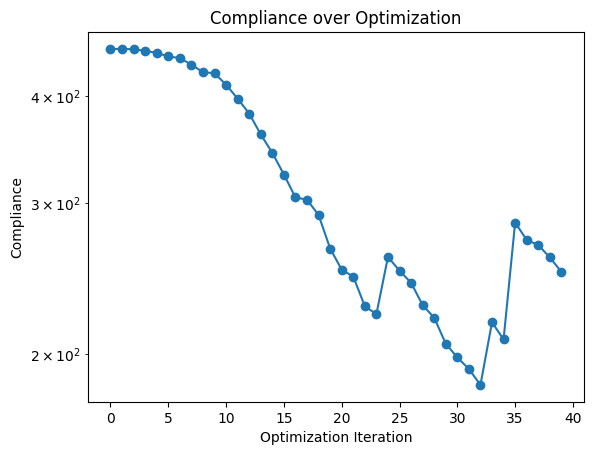

In [274]:
plt.plot(loss_hist[:40], marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

In [272]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist[:40]:
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow(
        sdf[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1
    )
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_x.gif", writer="pillow", fps=10)

In [273]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"tmp_img/mesh_optim_{i:03d}.png")